## 1. Installing Packages

In [4]:
# %pip install git+https://github.com/JaidedAI/EasyOCR.git
# %pip install -U git+https://github.com/madmaze/pytesseract.git
# %pip install language-tool-python
# %pip install mlx-lm
# %pip install transformers
# !pip install git+https://github.com/casics/nostril.git

## 2. Importing Packages

In [144]:
import pandas as pd
from datasets import load_dataset, get_dataset_split_names
import polars as pl
import easyocr
import hashlib
import cv2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
from bing_image_downloader import downloader
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pytesseract
from PIL import Image
from transformers import AutoModelForCausalLM, AutoTokenizer
import re
from language_tool_python import LanguageTool
from mlx_lm import load, generate
import language_tool_python  # For grammar correction
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import pytesseract
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import matplotlib.image as mpimg
from tqdm import tqdm




warnings.filterwarnings('ignore')
sns.set(style="whitegrid")
    
reader = easyocr.Reader(['en'], gpu=False)
pytesseract.pytesseract.tesseract_cmd = '/opt/homebrew/bin/tesseract'

Using CPU. Note: This module is much faster with a GPU.


## 3. Exploratory Data Analysis

In [16]:
splits = {'train': 'train.jsonl', 'validation': '**/dev_*.jsonl', 'test': '**/test_*.jsonl'}
train_df = pl.read_ndjson('hf://datasets/neuralcatcher/hateful_memes/' + splits['train'])
train_df.head()

shape: (5, 4)
┌───────┬───────────────┬───────┬─────────────────────────────────┐
│ id    ┆ img           ┆ label ┆ text                            │
│ ---   ┆ ---           ┆ ---   ┆ ---                             │
│ str   ┆ str           ┆ i64   ┆ str                             │
╞═══════╪═══════════════╪═══════╪═════════════════════════════════╡
│ 42953 ┆ img/42953.png ┆ 0     ┆ its their character not their … │
│ 23058 ┆ img/23058.png ┆ 0     ┆ don't be afraid to love again … │
│ 13894 ┆ img/13894.png ┆ 0     ┆ putting bows on your pet        │
│ 37408 ┆ img/37408.png ┆ 0     ┆ i love everything and everybod… │
│ 82403 ┆ img/82403.png ┆ 0     ┆ everybody loves chocolate chip… │
└───────┴───────────────┴───────┴─────────────────────────────────┘

In [17]:
label_counts = train_df['label'].value_counts().to_pandas()
label_counts['label'] = label_counts['label'].map({0: 'Not Hate', 1: 'Hate'})
label_counts

label  count
0  Not Hate   5481
1      Hate   3019

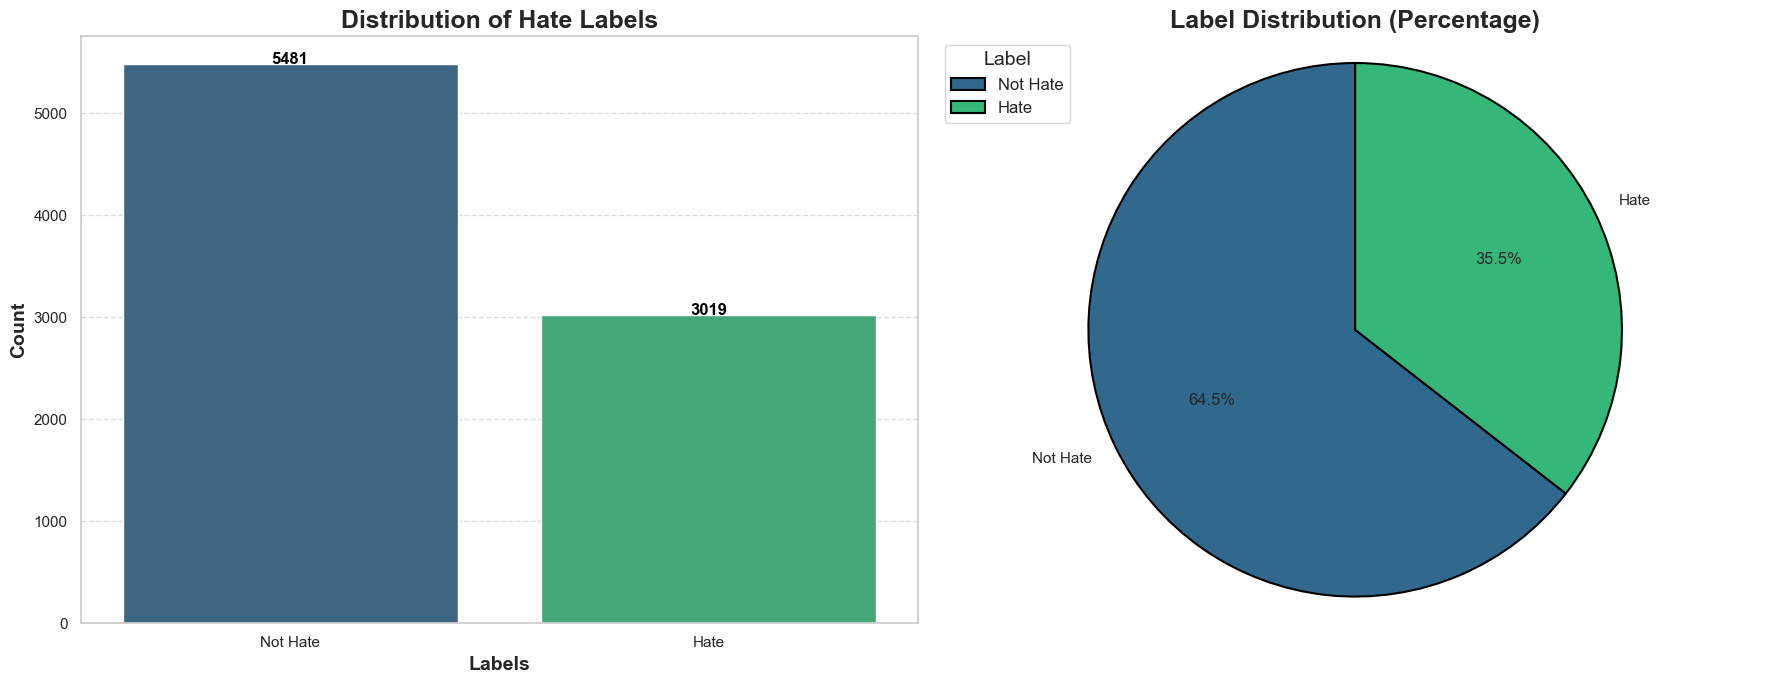

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# bar plot
sns.barplot(x=label_counts['label'], y=label_counts['count'], ax=axes[0], palette=viridis_palette)

for i, count in enumerate(label_counts['count']):
    axes[0].text(i, count + 0.2, str(count), ha='center', fontsize=12, color='black', fontweight='bold')

axes[0].set_title("Distribution of Hate Labels", fontsize=18, fontweight='bold')
axes[0].set_xlabel("Labels", fontsize=14, fontweight='bold')
axes[0].set_ylabel("Count", fontsize=14, fontweight='bold')
axes[0].grid(True, axis='y', linestyle='--', alpha=0.7)

# pie chart
axes[1].pie(label_counts['count'], labels=label_counts['label'], autopct='%1.1f%%', startangle=90, colors=viridis_palette, wedgeprops={'edgecolor': 'black', 'linewidth': 1.5})
axes[1].axis('equal')
axes[1].set_title("Label Distribution (Percentage)", fontsize=18, fontweight='bold')

axes[1].legend(
    labels=label_counts['label'],
    loc="upper left", 
    title="Label",
    fontsize=12,
    title_fontsize=14
)

plt.tight_layout()
plt.show()

<div class="alert alert-info" role="alert">
The data is significantly imbalanced as seen in the above image. To resolve this, instead of undersampling and losing data as well as using ineffective oversampling techniques such as smote or random oversampling, let's utilize web scraping to scrape around ~2000 harmful meme images from the internet to augment and balance the dataset. 
</div>

### 3.1 Web Scraping

In [156]:
queries = [
    "racism", "sexism", "homophobia", "transphobia", "hate speech", "violence", 
    "bullying", "body shaming", "mental illness stigma", "discrimination", 
    "hate crime", "toxic masculinity", "misogyny", "misandry", "anti-Semitism", "xenophobia", "ageism", "ableism", "fatphobia", 
    "nazi", "white supremacy", "KKK", "neo-nazi", "terrorism", 
    "gun violence", "school shootings", "abortion debate", "anti-vaccine", "conspiracy theories", 
    "covid misinformation", "climate change denial", "fake news", "radicalization", "ISIS", 
    "extremism", "terrorist attacks", "hate speech speech", "slut-shaming",
     "domestic violence", "racist humor", "sexist jokes", 
    "anti-LGBTQ", "transgender jokes", "homophobic jokes", "feminist hate", 
    "bullying memes", "stereotypes", "meme harassment", "dark humor", "graphic violence", 
    "gore", "death threats", "self-harm", "drug abuse", 
    "alcoholism", "profanity", "racist memes", "antisocial behavior", "trolling", 
    "catfishing", "scams", "hoaxes", "online abuse", "cults", "hate groups", 
    "gang violence", "organized crime", "gangster memes", "drug memes", "brutality", 
    "war crimes", "warfare memes", "militant memes", "extreme political views", "dictatorships", 
    "communism", "authoritarianism", "conspiracy theories memes", "unethical practices", 
    "greed", "wealth inequality", "anti-government", "radical political movements", 
    "controversial figures", "corruption", "violence against women",
    "illegal activities", "terrorist organizations", "online radicalization", 
    "extreme nationalism", "fake conspiracy theories", "death cults", "survivalism", "racist caricatures", 
    "cultural appropriation", "toxic fandoms", "misogynistic memes", "victim blaming", "hate symbols", 
    "swastika memes", "confederate flag memes", "bullying at school", "online hate speech", "terrorist memes", 
    "hate groups propaganda", "violent video games", "social media addiction", "toxic online communities", 
    "misinformation", "disinformation", "polarization", "online harassment", "cancel culture", 
    "outrage culture", "online shaming", "meme trolling", "internet mobs", "internet censorship", 
    "memes on controversial issues", "memes about mental health", 
    "memes mocking minorities", "celebrity abuse scandals", "gossip memes", "cultural criticism memes", 
    "historical revisionism", "disrespect towards the elderly", "harassment of public figures", 
    "toxic influencer culture", "fake beauty standards", "self-hate", "biphobia", "misogynoir"
]

<div class="alert alert-info" role="alert">
Above is a list of around 100+ harmful/toxic topics that was generated using chatgpt. The goal is to gather around 20 meme images from these topics which will come to around 2000 images, just enough to balance the dataset.
</div>

In [157]:
for query in tqdm(queries, desc="downloading memes from query", unit="query"):
    if "meme" not in query:
        query += " meme offensive"
    
    downloader.download(query, limit=20,  output_dir='dataset', adult_filter_off=True, force_replace=False, timeout=60, verbose=True)

downloading memes from query:   0%|                                                                | 0/132 [00:00<?, ?query/s]

[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/racism meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://www.gannett-cdn.com/presto/2020/06/13/PSIF/32f21d6b-c709-48df-807f-7f4d5eb3b431-Minnesota_Ave_Protest_009.JPG?crop=5519,3105,x0,y280&amp;width=3200&amp;height=1801&amp;format=pjpg&amp;auto=webp
[!] Issue getting: https://www.gannett-cdn.com/presto/2020/06/13/PSIF/32f21d6b-c709-48df-807f-7f4d5eb3b431-Minnesota_Ave_Protest_009.JPG?crop=5519,3105,x0,y280&amp;width=3200&amp;height=1801&amp;format=pjpg&amp;auto=webp
[!] Error:: HTTP Error 406: Not Acceptable
[%] Downloading Image #1 from https://ichef.bbci.co.uk/news/1024/branded_news/7924/production/_90821013_tweet_976.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://ichef.bbci.co.uk/news/976/cpsprodpb/A277/production/_90819514_newtweet_976.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://ichef

downloading memes from query:   1%|▍                                                       | 1/132 [00:26<56:51, 26.04s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/sexism meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://ichef.bbci.co.uk/news/320/cpsprodpb/A277/production/_90819514_newtweet_976.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://www.gannett-cdn.com/presto/2018/08/19/USAT/09e5037b-6ca2-4022-8495-e12374490284-VPC_SEXIST_SCHOOL_DESK_THUMB.png?width=3200&amp;height=1800&amp;fit=crop
[!] Issue getting: https://www.gannett-cdn.com/presto/2018/08/19/USAT/09e5037b-6ca2-4022-8495-e12374490284-VPC_SEXIST_SCHOOL_DESK_THUMB.png?width=3200&amp;height=1800&amp;fit=crop
[!] Error:: HTTP Error 406: Not Acceptable
[%] Downloading Image #2 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-11-1-240x225.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://theawesomedaily.com/wp-co

downloading memes from query:   2%|▊                                                       | 2/132 [00:47<50:34, 23.34s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/homophobia meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://a57.foxnews.com/static.foxnews.com/foxnews.com/content/uploads/2019/04/931/524/lgbtq.jpg?ve=1&amp;tl=1
[%] File Downloaded !

[%] Downloading Image #2 from http://images7.memedroid.com/images/UPLOADED95/53b37388ca6c3.jpeg
[%] File Downloaded !

[%] Downloading Image #3 from https://i.redd.it/3yi1dzoeofj51.jpg
[Error]Invalid image, not saving https://i.redd.it/3yi1dzoeofj51.jpg

[!] Issue getting: https://i.redd.it/3yi1dzoeofj51.jpg
[!] Error:: Invalid image, not saving https://i.redd.it/3yi1dzoeofj51.jpg

[%] Downloading Image #3 from https://cdn.vox-cdn.com/thumbor/8gzt6uLQIjordJb7UdByOjvsb9E=/0x0:3716x2500/920x0/filters:focal(0x0:3716x2500):no_upscale()/cdn.vox-cdn.com/uploads/chorus_asset/file/11538307/mbb_co

downloading memes from query:   2%|█▎                                                      | 3/132 [01:05<45:25, 21.13s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/transphobia meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://ichef.bbci.co.uk/news/976/cpsprodpb/AE8D/production/_103458644_3aed7c2f-8c04-446d-85a2-cb91c4c83c9f.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://a57.foxnews.com/static.foxnews.com/foxnews.com/content/uploads/2019/04/931/524/lgbtq.jpg?ve=1&amp;tl=1
[%] File Downloaded !

[%] Downloading Image #3 from https://static01.nyt.com/images/2018/10/22/us/23xp-trans3/23xp-trans3-videoSixteenByNine3000.jpg?year=2018&amp;h=1686&amp;w=3000&amp;sig=0x7243ca8bfe58af443aeeab4f34a96cc0&amp;tw=1
[%] File Downloaded !

[%] Downloading Image #4 from http://images7.memedroid.com/images/UPLOADED95/53b37388ca6c3.jpeg
[%] File Downloaded !

[%] Downloading Image #5 from https://thepinknews.com/wp-content/uploads/ima

downloading memes from query:   3%|█▋                                                      | 4/132 [01:39<55:10, 25.87s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/hate speech meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://ichef.bbci.co.uk/news/320/cpsprodpb/A277/production/_90819514_newtweet_976.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://uberhumor.com/wp-content/uploads/2019/05/zKzhMBF.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://venturebeat.com/wp-content/uploads/2020/05/hateful-memes-challlenge.png?w=1200&amp;strip=all
[%] File Downloaded !

[%] Downloading Image #4 from https://images.theconversation.com/files/243088/original/file-20181030-76416-1vp01ih.jpg?ixlib=rb-1.1.0&amp;q=15&amp;auto=format&amp;w=754&amp;h=698&amp;fit=crop&amp;dpr=3
[%] File Downloaded !

[%] Downloading Image #5 from https://theawesomedaily.com/wp-content/uploads/2017/01/offensive-memes-34-1-750x729.jpeg
[%] Fi

downloading memes from query:   4%|██                                                      | 5/132 [02:00<50:59, 24.09s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/violence meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://www.washingtonpost.com/resizer/t_tbqu9FS7m42LD_Nc2Wr7WmDS4=/1484x0/arc-anglerfish-washpost-prod-washpost.s3.amazonaws.com/public/UPO4HUU6PIZHNK3XZTMKEKMHB4.jpg
[!] Issue getting: https://www.washingtonpost.com/resizer/t_tbqu9FS7m42LD_Nc2Wr7WmDS4=/1484x0/arc-anglerfish-washpost-prod-washpost.s3.amazonaws.com/public/UPO4HUU6PIZHNK3XZTMKEKMHB4.jpg
[!] Error:: Remote end closed connection without response
[%] Downloading Image #1 from https://images.squarespace-cdn.com/content/v1/5b05730bf407b4d26de71655/1604046944172-WUAZVQTFNLBNJ1GZW70S/Tory+Lanez+Meg+Thee+Stallion+Meme
[%] File Downloaded !

[%] Downloading Image #2 from https://theawesomedaily.com/wp-content/uploads/2017/01/offensive-memes-34-1-750x729.jpeg
[%] Fi

downloading memes from query:   5%|██▍                                                   | 6/132 [02:41<1:03:17, 30.14s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/bullying meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://images3.memedroid.com/images/UPLOADED868/60598e7667b32.jpeg
[%] File Downloaded !

[%] Downloading Image #2 from https://s-media-cache-ak0.pinimg.com/736x/0c/d1/bb/0cd1bbd4811939465a11d32fbca60fce.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://s3.us-east-1.amazonaws.com/world-website-storage/wng-prod/_1500x937_crop_center-center_82_line/nu9e2uq.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-20-1.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-27-1.jpg
[%] File Downloaded !

[%] Downloading Image #6 from https://www.schulranzen.n

downloading memes from query:   5%|██▉                                                     | 7/132 [03:05<58:05, 27.89s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/body shaming meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://ichef.bbci.co.uk/news/1024/branded_news/A52A/production/_93028224_funnyrugbyleague.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://ichef.bbci.co.uk/news/976/cpsprodpb/124C9/production/_93035947_ynfa_asylum_pixelated_5.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://ichef.bbci.co.uk/news/976/cpsprodpb/13CA3/production/_92995018_littlelizziev.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://www.thehealthy.com/wp-content/uploads/2018/04/10-Best-Ever-Comebacks-to-Body-Shaming-1.jpg?resize=1024
[!] Issue getting: https://www.thehealthy.com/wp-content/uploads/2018/04/10-Best-Ever-Comebacks-to-Body-Shaming-1.jpg?resize=1024
[!] Error:: HTTP Error 403: Forbidden
[%] Do

downloading memes from query:   6%|███▍                                                    | 8/132 [03:26<53:03, 25.68s/query]

[%] File Downloaded !

[%] Downloading Image #20 from https://akashgautam.com/wp-content/uploads/2018/10/meme-on-body-shaming.png
[!] Issue getting: https://akashgautam.com/wp-content/uploads/2018/10/meme-on-body-shaming.png
[!] Error:: Remote end closed connection without response
[%] Downloading Image #20 from https://static.wikia.nocookie.net/starwars/images/4/4e/ObiWanHS-SWE.jpg/revision/latest?cb=20111115052816
[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/mental illness stigma meme offensive


[!!]Indexing page: 1

[%] Indexed 21 Images on Page 1.


[%] Downloading Image #1 from http://sova.pitt.edu/wp-content/uploads/2018/08/Charlie.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://themighty.com/wp-content/uploads/2017/01/Photo-Jan-27-8-28-14-AM.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://www.al.com/resizer/LbxNFj5BEQ7td-okWTDOCWzntd4=

downloading memes from query:   7%|███▊                                                    | 9/132 [03:45<48:45, 23.79s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/discrimination meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-20-1.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-28-1.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-9-1.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://www.gannett-cdn.com/presto/2018/10/15/PSTP/48608442-6fa6-454e-bfb3-09672263b66d-6EC17B91-BB58-461A-8A82-40D0BD6439ED.png?crop=749,427,x0,y465&amp;width=3200&amp;height=1680&amp;fit=bounds
[!] Issue getting: https://www.gannett-cdn.com/presto/2018/10/15/PSTP/48608442-6fa6-454e-bfb3-09672263b66d-6EC17B91-

downloading memes from query:   8%|████▏                                                  | 10/132 [04:08<47:33, 23.39s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/hate crime meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from http://cdn.cnn.com/cnnnext/dam/assets/150618184401-what-is-a-hate-crime-00001618-super-169.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://www.westyorkshire.police.uk/sites/default/files/2017-10/hate-crime-infographic-final-image.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://www.gannett-cdn.com/presto/2023/01/18/USAT/8c3e1fdd-ed35-49da-a49b-acfd28c1b9ce-AP_Anti_Asian_Hate_Crimes.jpg?crop=2999,1687,x0,y112&amp;width=2999&amp;height=1687&amp;format=pjpg&amp;auto=webp
[!] Issue getting: https://www.gannett-cdn.com/presto/2023/01/18/USAT/8c3e1fdd-ed35-49da-a49b-acfd28c1b9ce-AP_Anti_Asian_Hate_Crimes.jpg?crop=2999,1687,x0,y112&amp;width=2999&amp;height=1687&amp;format=pjpg&amp;auto=webp
[!

downloading memes from query:   8%|████▌                                                  | 11/132 [04:32<47:38, 23.63s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/toxic masculinity meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from http://shrink4men.com/wp-content/uploads/2018/11/Shrink4Men_masculinity-isnt-toxic-narcissists-of-both-genders-are-1.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://images.theconversation.com/files/257264/original/file-20190205-86202-1pb321c.jpg?ixlib=rb-1.1.0&amp;rect=0%2C313%2C4989%2C2494&amp;q=45&amp;auto=format&amp;w=1356&amp;h=668&amp;fit=crop
[%] File Downloaded !

[%] Downloading Image #3 from https://uploads.dailydot.com/2018/05/im_gay_straight_meme.jpg?q=65&amp;auto=format&amp;w=2270&amp;ar=2:1&amp;fit=crop
[%] File Downloaded !

[%] Downloading Image #4 from https://i.imgflip.com/2q7cyc.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://www.mememaker.net/static/images/meme

downloading memes from query:   9%|█████                                                  | 12/132 [04:59<49:11, 24.59s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/misogyny meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://www.washingtonpost.com/news/the-intersect/wp-content/uploads/sites/32/2014/08/fark2.jpg
[!] Issue getting: https://www.washingtonpost.com/news/the-intersect/wp-content/uploads/sites/32/2014/08/fark2.jpg
[!] Error:: Remote end closed connection without response
[%] Downloading Image #1 from http://images.huffingtonpost.com/2016-06-02-1464896909-2416723-IMG_5439.PNG
[%] File Downloaded !

[%] Downloading Image #2 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-20-1.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-9-1.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://theawesomedaily.com/

downloading memes from query:  10%|█████▍                                                 | 13/132 [05:39<57:53, 29.19s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/misandry meme offensive


[!!]Indexing page: 1

[%] Indexed 23 Images on Page 1.


[%] Downloading Image #1 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-11-1-240x225.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-20-1.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-feat-1-620x400.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://absolutelymaybe.plos.org/wp-content/uploads/sites/8/legacy-featured-images/Sexist-club-16x9.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://cdn.quotesgram.com/img/4/31/1819713416-tumblr_m5884d4rzR1rp5vopo1_1280.png
[%] File Downloaded !

[%] Downloading Image #6 from https:

downloading memes from query:  11%|█████▊                                                 | 14/132 [05:51<47:36, 24.21s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/anti-Semitism meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://static01.nyt.com/images/2018/10/29/us/29ANTISEMITISM-1/merlin_145979652_c7906428-8d36-4094-a9b7-072522e7f500-videoSixteenByNine3000.jpg?year=2018&amp;h=1687&amp;w=3000&amp;s=e22b38b5db390c0729d15a6f9a7ba8036724961959e6979b79c3f52fc9fbf7da&amp;k=ZQJBKqZ0VN&amp;tw=1
[%] File Downloaded !

[%] Downloading Image #2 from https://static01.nyt.com/images/2021/05/24/opinion/24stephens-lead/24stephens-lead-videoSixteenByNineJumbo1600.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://static01.nyt.com/images/2019/02/20/world/20FRANCE1/20FRANCE1-videoSixteenByNine3000.jpg?year=2019&amp;h=1689&amp;w=3000&amp;sig=0x4e698ff2f061a33fefc259efe6836e8d&amp;tw=1
[%] File Downloaded !

[%] Downloading Image #4 from

downloading memes from query:  11%|██████▎                                                | 15/132 [06:09<43:18, 22.21s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/xenophobia meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://pbs.twimg.com/media/FtidoLpWAAQ31v8.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://img.haikudeck.com/mg/187C0033-8905-4F5A-B81A-2FF8851A718C.jpg?theme=Illuminati&amp;rasterSignature=48f8109906b836ec3312aced161754de&amp;imageFilter=false
[%] File Downloaded !

[%] Downloading Image #3 from https://i.pinimg.com/originals/3f/cb/40/3fcb40fd5af62e2f538a5356f949db43.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://www.memecreator.org/static/images/memes/3897313.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://i.imgflip.com/2vtt55.jpg
[%] File Downloaded !

[%] Downloading Image #6 from https://imageproxy.ifunny.co/crop:x-20,resize:320x,crop:x800,quality:90x75/images/86

downloading memes from query:  12%|██████▋                                                | 16/132 [06:44<50:34, 26.16s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/ageism meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://www.slidegeeks.com/pics/dgm/l/m/Meme_For_Ageism_Prejudice_At_Offices_Training_Ppt_Slide_1-.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://media.istockphoto.com/vectors/ageism-age-discrimination-the-boss-fires-the-grandfather-fire-the-old-vector-id1370650427?k=20&amp;m=1370650427&amp;s=612x612&amp;w=0&amp;h=DcNa1CS_tBRZUqc27wQ3_GhezsPrWr_O6FUEuOQ4w6A=
[!] Issue getting: https://media.istockphoto.com/vectors/ageism-age-discrimination-the-boss-fires-the-grandfather-fire-the-old-vector-id1370650427?k=20&amp;m=1370650427&amp;s=612x612&amp;w=0&amp;h=DcNa1CS_tBRZUqc27wQ3_GhezsPrWr_O6FUEuOQ4w6A=
[!] Error:: HTTP Error 400: Bad Request
[%] Downloading Image #2 from https://media.istockphoto.com/vectors/agei

downloading memes from query:  13%|███████                                                | 17/132 [07:19<54:54, 28.65s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/ableism meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://wordpressua.uark.edu/uofapartners/files/2017/05/Ableism-poster-thumbnail-768x1024.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://dasg7xwmldix6.cloudfront.net/episodes/285483_ilBklSGe.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://theawesomedaily.com/wp-content/uploads/2017/01/offensive-memes-34-1-750x729.jpeg
[%] File Downloaded !

[%] Downloading Image #4 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-20-1.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://events.wm.edu/images/event_uploads/caanderson_2023_04_25_17_25_40.jpg
[%] File Downloaded !

[%] Downloading Image #6 from https://pbs.twimg.com/media/FYNE-m2WIAA4wsK?format=jpg&

downloading memes from query:  14%|███████▍                                               | 18/132 [07:45<53:02, 27.92s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/fatphobia meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://i.imgflip.com/7ukfqw.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://media.thetab.com/blogs.dir/90/files/2022/08/untitled-design-2022-08-05t112941272.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://media.glamour.com/photos/5e8802832b61c800089a18bb/master/w_1600,c_limit/embed.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://www.lboro.ac.uk/media/wwwlboroacuk/external/content/mediacentre/pressreleases/2018/10/Fat-women-logic.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://media-cldnry.s-nbcnews.com/image/upload/t_nbcnews-fp-1200-630,f_auto,q_auto:best/streams/2013/July/130725/8C8394699-obesity_backlash-710064554_v2.jpg
[%] File Downloaded !

[%] Dow

downloading memes from query:  14%|███████▉                                               | 19/132 [07:59<44:49, 23.80s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/nazi meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://israelnoticias.com/wp-content/uploads/2022/11/tuit-de-Musk.webp
[%] File Downloaded !

[%] Downloading Image #2 from https://www.gannett-cdn.com/-mm-/2cb55a089d6d2387f73d0f3f895c4f132e602bfc/c=253-0-1050-450/local/-/media/2015/01/13/USATODAY/USATODAY/635567614190653488-Screen-Shot-2015-01-13-at-3.52.20-PM.jpg?width=3200&amp;height=1680&amp;fit=crop
[%] File Downloaded !

[%] Downloading Image #3 from https://www.washingtonpost.com/wp-apps/imrs.php?src=http://www.washingtonpost.com/news/grade-point/wp-content/uploads/sites/42/2017/02/Capture.jpg&amp;w=1440
[!] Issue getting: https://www.washingtonpost.com/wp-apps/imrs.php?src=http://www.washingtonpost.com/news/grade-point/wp-content/uploads/sites/42/2017/02/Capture.jpg

downloading memes from query:  15%|████████▎                                              | 20/132 [08:31<48:56, 26.22s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/white supremacy meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://static01.nyt.com/images/2017/08/16/us/16dc-assess-alpha/16dc-assess-alpha-videoSixteenByNine3000.jpg?year=2017&amp;h=1687&amp;w=3000&amp;sig=0x1e06202609bb53319e086c907de08cdb&amp;tw=1
[%] File Downloaded !

[%] Downloading Image #2 from https://ichef.bbci.co.uk/news/640/cpsprodpb/15CF3/production/_97313398_kkk.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://images3.memedroid.com/images/UPLOADED765/606c89b7a5078.jpeg
[%] File Downloaded !

[%] Downloading Image #4 from https://i.redd.it/lbpid4kybvq61.png
[Error]Invalid image, not saving https://i.redd.it/lbpid4kybvq61.png

[!] Issue getting: https://i.redd.it/lbpid4kybvq61.png
[!] Error:: Invalid image, not saving https://i.redd.it/lbpid4ky

downloading memes from query:  16%|████████▊                                              | 21/132 [08:53<46:06, 24.93s/query]

[%] File Downloaded !

[%] Downloading Image #20 from https://www.isdglobal.org/wp-content/uploads/2022/10/Screenshot-2022-10-04-at-13.59.15.png
[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/KKK meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://cdn.cnn.com/cnnnext/dam/assets/120613122520-kkk-14-horizontal-large-gallery.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://static01.nyt.com/images/2016/02/29/opinion/29chappatte/29chappatte-articleLarge.jpg?quality=75&amp;auto=webp&amp;disable=upscale
[%] File Downloaded !

[%] Downloading Image #3 from https://content.attn.com/sites/default/files/trump-meme.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://us-east-1.tchyn.io/snopes-production/uploads/2017/01/trump-kkk.jpg
[!] Issue getting: https://us-east-1.tchyn.io/snopes-production/uploads/

downloading memes from query:  17%|████████▊                                            | 22/132 [10:17<1:18:32, 42.84s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/neo-nazi meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://israelnoticias.com/wp-content/uploads/2022/11/tuit-de-Musk.webp
[%] File Downloaded !

[%] Downloading Image #2 from https://www.washingtonpost.com/pbox.php?url=http://www.washingtonpost.com/news/grade-point/wp-content/uploads/sites/42/2017/02/Capture.jpg&amp;w=1484&amp;op=resize&amp;opt=1&amp;filter=antialias&amp;t=20170517
[!] Issue getting: https://www.washingtonpost.com/pbox.php?url=http://www.washingtonpost.com/news/grade-point/wp-content/uploads/sites/42/2017/02/Capture.jpg&amp;w=1484&amp;op=resize&amp;opt=1&amp;filter=antialias&amp;t=20170517
[!] Error:: Remote end closed connection without response
[%] Downloading Image #2 from https://i.guim.co.uk/img/media/a38d271773409b7ac7383b493a7283b7ec57bee7/0_30_46

downloading memes from query:  17%|█████████▏                                           | 23/132 [10:49<1:11:47, 39.52s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/terrorism meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://www.washingtonpost.com/wp-apps/imrs.php?src=https://arc-anglerfish-washpost-prod-washpost.s3.amazonaws.com/public/4CD5AZQWFYYPNBMKKO63WW2PZY.jpg&amp;w=916
[!] Issue getting: https://www.washingtonpost.com/wp-apps/imrs.php?src=https://arc-anglerfish-washpost-prod-washpost.s3.amazonaws.com/public/4CD5AZQWFYYPNBMKKO63WW2PZY.jpg&amp;w=916
[!] Error:: The read operation timed out
[%] Downloading Image #1 from http://www.gannett-cdn.com/-mm-/6f2262319540bf69a02d5ce0139cad27e53e5991/c=0-10-768-444&amp;r=x633&amp;c=1200x630/local/-/media/2016/01/19/USATODAY/USATODAY/635888143020110643-terror.JPG
[%] File Downloaded !

[%] Downloading Image #2 from https://ctc.westpoint.edu/wp-content/uploads/2016/07/CTC-SENTINEL_Vol9Iss7

downloading memes from query:  18%|█████████▋                                           | 24/132 [12:15<1:35:59, 53.33s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/gun violence meme offensive


[!!]Indexing page: 1

[%] Indexed 21 Images on Page 1.


[%] Downloading Image #1 from https://www.washingtonpost.com/resizer/t_tbqu9FS7m42LD_Nc2Wr7WmDS4=/1484x0/arc-anglerfish-washpost-prod-washpost.s3.amazonaws.com/public/UPO4HUU6PIZHNK3XZTMKEKMHB4.jpg
[!] Issue getting: https://www.washingtonpost.com/resizer/t_tbqu9FS7m42LD_Nc2Wr7WmDS4=/1484x0/arc-anglerfish-washpost-prod-washpost.s3.amazonaws.com/public/UPO4HUU6PIZHNK3XZTMKEKMHB4.jpg
[!] Error:: The read operation timed out
[%] Downloading Image #1 from http://publisher.attn.com/sites/default/files/10387018_773089182726543_8370823349900418606_o.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://www.usnews.com/dims4/USNEWS/74383cf/2147483647/resize/1200x&gt;/quality/85/?url=http:%2F%2Fcom-usnews-beam-media.s3.amazonaws.com%2F21%2F28%2F9

downloading memes from query:  19%|██████████                                           | 25/132 [15:42<2:57:25, 99.50s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/school shootings meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from http://cdn.cnn.com/cnnnext/dam/assets/180216112715-01-luckovich-cartoons-super-169.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://cdn.cnn.com/cnnnext/dam/assets/180216113154-04-luckovich-cartoons-super-169.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://cdn.cnn.com/cnnnext/dam/assets/180216112715-01-luckovich-cartoons-live-video.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://m.wsj.net/video/20180216/021618victims/021618victims_1280x720.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://www.washingtonpost.com/wp-apps/imrs.php?src=https://arc-anglerfish-washpost-prod-washpost.s3.amazonaws.com/public/M3NM2NRYAE2APNNBOCB7RN2GKQ.jpg&amp;w=767
[!] Issue 

downloading memes from query:  20%|██████████▏                                         | 26/132 [17:48<3:09:40, 107.36s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/abortion debate meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://www.gannett-cdn.com/media/USATODAY/USATODAY/2013/01/22/012213indy-abortion-16_9.jpg?width=3200&amp;height=1680&amp;fit=crop
[!] Issue getting: https://www.gannett-cdn.com/media/USATODAY/USATODAY/2013/01/22/012213indy-abortion-16_9.jpg?width=3200&amp;height=1680&amp;fit=crop
[!] Error:: HTTP Error 406: Not Acceptable
[%] Downloading Image #1 from https://www.washingtonpost.com/wp-apps/imrs.php?src=https://arc-anglerfish-washpost-prod-washpost.s3.amazonaws.com/public/ZC7AHZEOYEI6TD3JUJ4V7SRTIM.jpg&amp;w=1440
[!] Issue getting: https://www.washingtonpost.com/wp-apps/imrs.php?src=https://arc-anglerfish-washpost-prod-washpost.s3.amazonaws.com/public/ZC7AHZEOYEI6TD3JUJ4V7SRTIM.jpg&amp;w=1440
[!] Error:: The read 

downloading memes from query:  20%|██████████▋                                         | 27/132 [22:15<4:31:47, 155.31s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/anti-vaccine meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://ichef.bbci.co.uk/news/480/cpsprodpb/F3DC/production/_115682426_control-comp-nc.png.webp
[%] File Downloaded !

[%] Downloading Image #2 from https://ichef.bbci.co.uk/news/480/cpsprodpb/A5BC/production/_115682424_drake-false-nc.png.webp
[%] File Downloaded !

[%] Downloading Image #3 from https://www.gannett-cdn.com/-mm-/eb34b9888702cb3f4641b6ee49362a859a5dfd45/c=0-0-2309-1299/local/-/media/2020/09/13/USATODAY/usatsports/hand-picking-up-covid-19-vaccine-bottle.jpg?width=2309&amp;height=1299&amp;fit=crop&amp;format=pjpg&amp;auto=webp
[%] File Downloaded !

[%] Downloading Image #4 from https://ichef.bbci.co.uk/news/640/cpsprodpb/11AEC/production/_115682427_gates-scaremongering-nc.png
[%] File Downloaded !

[%] D

downloading memes from query:  21%|███████████                                         | 28/132 [22:44<3:23:54, 117.64s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/conspiracy theories meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://static01.nyt.com/images/2016/02/28/us/trump-conspiraciesALT/trump-conspiraciesALT-superJumbo-v2.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://breakforbuzz.com/wp-content/uploads/2020/09/3426937-33-9.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://saidit.net/media/9gIQUNVMiLJfrPJ4LrDg5X9H-Ohfo9rufhyhbRL8o0Y.jpg
[!] Issue getting: https://saidit.net/media/9gIQUNVMiLJfrPJ4LrDg5X9H-Ohfo9rufhyhbRL8o0Y.jpg
[!] Error:: HTTP Error 403: Forbidden
[%] Downloading Image #3 from https://static3.thethingsimages.com/wordpress/wp-content/uploads/2016/09/conspiracy.jpg
[%] File Downloaded !

[%] Downloading Image #4 from http://rightedition.com/wp-content/uploads/2015/05/conspiracy-t

downloading memes from query:  22%|███████████▍                                        | 29/132 [24:12<3:06:33, 108.67s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/covid misinformation meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://static.foxnews.com/foxnews.com/content/uploads/2021/11/not-funny-didnt-laugh.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://www.stura.uni-heidelberg.de/wp-content/uploads/VS/Corona/Handwaschanleitung.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://ichef.bbci.co.uk/news/640/cpsprodpb/A5BC/production/_115682424_drake-false-nc.png
[%] File Downloaded !

[%] Downloading Image #4 from https://forums.somd.com/attachments/disinfo-jpg.158301/
[Error]Invalid image, not saving https://forums.somd.com/attachments/disinfo-jpg.158301/

[!] Issue getting: https://forums.somd.com/attachments/disinfo-jpg.158301/
[!] Error:: Invalid image, not saving https://forums.somd.com/attachment

downloading memes from query:  23%|████████████                                         | 30/132 [24:40<2:23:21, 84.33s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/climate change denial meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://shoutslogans.com/wp-content/uploads/2015/04/global-warming-meme.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://ichef.bbci.co.uk/news/976/cpsprodpb/106DD/production/_123939276_b25cddbc-6a9b-42d9-bbf0-3ce2ad070287.png
[%] File Downloaded !

[%] Downloading Image #3 from https://umd-today.transforms.svdcdn.com/production/hero/climate-change-memes_1920x1080.jpg?w=1200&amp;h=630&amp;q=82&amp;auto=format&amp;fit=crop&amp;dm=1681916392&amp;s=c694ff8af4b112a0a62fffdcde104994
[!] Issue getting: https://umd-today.transforms.svdcdn.com/production/hero/climate-change-memes_1920x1080.jpg?w=1200&amp;h=630&amp;q=82&amp;auto=format&amp;fit=crop&amp;dm=1681916392&amp;s=c694ff8af4b112a0a62fffdcde10499

downloading memes from query:  23%|████████████▍                                        | 31/132 [25:03<1:51:14, 66.09s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/fake news meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://www.washingtonpost.com/wp-apps/imrs.php?src=https://arc-anglerfish-washpost-prod-washpost.s3.amazonaws.com/public/C7MVQXSRMIZZXKNYEFPXQNX3IY.jpg&amp;w=1440
[!] Issue getting: https://www.washingtonpost.com/wp-apps/imrs.php?src=https://arc-anglerfish-washpost-prod-washpost.s3.amazonaws.com/public/C7MVQXSRMIZZXKNYEFPXQNX3IY.jpg&amp;w=1440
[!] Error:: Remote end closed connection without response
[%] Downloading Image #1 from http://mediad.publicbroadcasting.net/p/wxxi/files/styles/x_large/public/201801/ntk_18_01_18_segment_2_fake_news_still.jpg
[!] Issue getting: http://mediad.publicbroadcasting.net/p/wxxi/files/styles/x_large/public/201801/ntk_18_01_18_segment_2_fake_news_still.jpg
[!] Error:: HTTP Error 503: Serv

downloading memes from query:  24%|████████████▊                                        | 32/132 [25:57<1:44:07, 62.47s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/radicalization meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://theawesomedaily.com/wp-content/uploads/2017/01/offensive-memes-34-1-750x729.jpeg
[%] File Downloaded !

[%] Downloading Image #2 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-20-1.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://www.gannett-cdn.com/presto/2018/10/15/PSTP/48608442-6fa6-454e-bfb3-09672263b66d-6EC17B91-BB58-461A-8A82-40D0BD6439ED.png?crop=749,427,x0,y465&amp;width=3200&amp;height=1680&amp;fit=bounds
[!] Issue getting: https://www.gannett-cdn.com/presto/2018/10/15/PSTP/48608442-6fa6-454e-bfb3-09672263b66d-6EC17B91-BB58-461A-8A82-40D0BD6439ED.png?crop=749,427,x0,y465&amp;width=3200&amp;height=1680&amp;fit=bounds
[!] Error:: HTTP Error 406: Not Ac

downloading memes from query:  25%|█████████████▎                                       | 33/132 [26:22<1:24:15, 51.06s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/ISIS meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://metro.co.uk/wp-content/uploads/2015/11/isis-mercedes.jpg?quality=90&amp;strip=all&amp;zoom=1&amp;resize=540%2C357
[%] File Downloaded !

[%] Downloading Image #2 from https://tm.usembassy.gov/wp-content/uploads/sites/124/ISIS_Meme_twitter.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://static.nexilia.it/giornalettismo/2015/11/ISIS-paperette-duckdaesh-spazzoloni.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://static.timesofisrael.com/www/uploads/2014/08/BvlCVP5IYAAAWjo.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://images-na.ssl-images-amazon.com/images/S/compressed.photo.goodreads.com/books/1425328180i/25056545.jpg
[%] File Downloaded !

[%] Downloading Image #6 from

downloading memes from query:  26%|█████████████▋                                       | 34/132 [26:41<1:07:59, 41.63s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/extremism meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://3.bp.blogspot.com/-xLawsaV3b4Q/UWdhXvt2p0I/AAAAAAAAADs/_5LZ4tx5RhI/s1600/IMG_1597.PNG
[%] File Downloaded !

[%] Downloading Image #2 from https://s-media-cache-ak0.pinimg.com/736x/0c/d1/bb/0cd1bbd4811939465a11d32fbca60fce.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://theawesomedaily.com/wp-content/uploads/2017/01/offensive-memes-34-1-750x729.jpeg
[%] File Downloaded !

[%] Downloading Image #4 from https://theawesomedaily.com/wp-content/uploads/2017/01/offensive-memes-32-1.jpeg
[%] File Downloaded !

[%] Downloading Image #5 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-11-1-240x225.jpg
[%] File Downloaded !

[%] Downloading Image #6 from https://theawesomeda

downloading memes from query:  27%|██████████████▌                                        | 35/132 [26:58<55:15, 34.18s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/terrorist attacks meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://www.washingtonpost.com/wp-apps/imrs.php?src=https://arc-anglerfish-washpost-prod-washpost.s3.amazonaws.com/public/4CD5AZQWFYYPNBMKKO63WW2PZY.jpg&amp;w=916
[!] Issue getting: https://www.washingtonpost.com/wp-apps/imrs.php?src=https://arc-anglerfish-washpost-prod-washpost.s3.amazonaws.com/public/4CD5AZQWFYYPNBMKKO63WW2PZY.jpg&amp;w=916
[!] Error:: Remote end closed connection without response
[%] Downloading Image #1 from http://www.gannett-cdn.com/-mm-/6f2262319540bf69a02d5ce0139cad27e53e5991/c=0-10-768-444&amp;r=x633&amp;c=1200x630/local/-/media/2016/01/19/USATODAY/USATODAY/635888143020110643-terror.JPG
[%] File Downloaded !

[%] Downloading Image #2 from https://ctc.westpoint.edu/wp-content/uploads/2016

downloading memes from query:  27%|██████████████▉                                        | 36/132 [27:38<57:31, 35.95s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/hate speech speech meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://ichef.bbci.co.uk/news/320/cpsprodpb/A277/production/_90819514_newtweet_976.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://uberhumor.com/wp-content/uploads/2019/05/zKzhMBF.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://venturebeat.com/wp-content/uploads/2020/05/hateful-memes-challlenge.png?w=1200&amp;strip=all
[%] File Downloaded !

[%] Downloading Image #4 from https://images.theconversation.com/files/243088/original/file-20181030-76416-1vp01ih.jpg?ixlib=rb-1.1.0&amp;q=15&amp;auto=format&amp;w=754&amp;h=698&amp;fit=crop&amp;dpr=3
[%] File Downloaded !

[%] Downloading Image #5 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-9-1.jpg
[%] 

downloading memes from query:  28%|███████████████▍                                       | 37/132 [27:58<49:17, 31.13s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/slut-shaming meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://elite.nyc3.cdn.digitaloceanspaces.com/2017/10/slut-shaming-meme-10.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://imgix.mic.com/mic/qdwxesh82vtgayxnfxjgbdra0hee8o8gcxzhk4m4xhymssvthau4wsvklwmbme7b.jpg?w=349&amp;fit=max&amp;auto=format%2Ccompress&amp;cs=srgb&amp;q=70&amp;dpr=2
[%] File Downloaded !

[%] Downloading Image #3 from https://bullygeneration.files.wordpress.com/2017/03/slutshaming2.png
[Error]Invalid image, not saving https://bullygeneration.files.wordpress.com/2017/03/slutshaming2.png

[!] Issue getting: https://bullygeneration.files.wordpress.com/2017/03/slutshaming2.png
[!] Error:: Invalid image, not saving https://bullygeneration.files.wordpress.com/2017/03/slutshaming2.png

[%]

downloading memes from query:  29%|███████████████▊                                       | 38/132 [28:15<42:10, 26.92s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/domestic violence meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://www.washingtonpost.com/resizer/t_tbqu9FS7m42LD_Nc2Wr7WmDS4=/1484x0/arc-anglerfish-washpost-prod-washpost.s3.amazonaws.com/public/UPO4HUU6PIZHNK3XZTMKEKMHB4.jpg
[!] Issue getting: https://www.washingtonpost.com/resizer/t_tbqu9FS7m42LD_Nc2Wr7WmDS4=/1484x0/arc-anglerfish-washpost-prod-washpost.s3.amazonaws.com/public/UPO4HUU6PIZHNK3XZTMKEKMHB4.jpg
[!] Error:: Remote end closed connection without response
[%] Downloading Image #1 from https://bythebaykinesiology.com.au/wp-content/uploads/2021/02/Domestic-Violence-meme.png
[!] Issue getting: https://bythebaykinesiology.com.au/wp-content/uploads/2021/02/Domestic-Violence-meme.png
[!] Error:: Remote end closed connection without response
[%] Downloading Image #1

downloading memes from query:  30%|████████████████▎                                      | 39/132 [29:11<55:03, 35.52s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/racist humor meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://i.imgflip.com/1u1641.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://www.thewrap.com/wp-content/uploads/2017/03/16996082_995760150524887_5296235299214348721_n.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://bloximages.chicago2.vip.townnews.com/nwitimes.com/content/tncms/assets/v3/editorial/3/08/308736bd-c3c4-52b5-921f-01747bbd6a16/5ebb0ecab037f.image.jpg?resize=1200%2C1384
[%] File Downloaded !

[%] Downloading Image #4 from https://uberhumor.com/wp-content/uploads/2015/03/XDqtm15.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://www.gannett-cdn.com/presto/2018/10/15/PSTP/48608442-6fa6-454e-bfb3-09672263b66d-6EC17B91-BB58-461A-8A82-40D0BD6439ED.png?crop=749,427,

downloading memes from query:  30%|████████████████▋                                      | 40/132 [29:29<46:41, 30.45s/query]

[%] File Downloaded !

[%] Downloading Image #20 from https://ichef.bbci.co.uk/news/1024/branded_news/7924/production/_90821013_tweet_976.jpg
[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/sexist jokes meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://www.washingtonpost.com/wp-apps/imrs.php?src=https://arc-anglerfish-washpost-prod-washpost.s3.amazonaws.com/public/TH7RD7S5CBDUNL4CH7QIKX5KYQ.png&amp;w=1484
[!] Issue getting: https://www.washingtonpost.com/wp-apps/imrs.php?src=https://arc-anglerfish-washpost-prod-washpost.s3.amazonaws.com/public/TH7RD7S5CBDUNL4CH7QIKX5KYQ.png&amp;w=1484
[!] Error:: The read operation timed out
[%] Downloading Image #1 from https://images.indianexpress.com/2016/09/feminism-meme-ad-e1475052946594.jpg
[!] Issue getting: https://images.indianexpress.com/2016/09/feminism-meme-ad-e147505294659

downloading memes from query:  31%|████████████████▍                                    | 41/132 [30:48<1:08:00, 44.84s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/anti-LGBTQ meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://www.gannett-cdn.com/presto/2019/06/14/USAT/4714d889-bd2a-4ec9-988a-ff931ce05b3a-RectThumb03.png?quality=10
[%] File Downloaded !

[%] Downloading Image #2 from https://a57.foxnews.com/static.foxnews.com/foxnews.com/content/uploads/2019/04/931/524/lgbtq.jpg?ve=1&amp;tl=1
[%] File Downloaded !

[%] Downloading Image #3 from https://www.washingtonpost.com/resizer/vuS8prQEpR805tEascMtTm2pRT8=/1484x0/arc-anglerfish-washpost-prod-washpost.s3.amazonaws.com/public/FOL7BHNHWAY4LK2OYOWZXXYAXY.jpg
[!] Issue getting: https://www.washingtonpost.com/resizer/vuS8prQEpR805tEascMtTm2pRT8=/1484x0/arc-anglerfish-washpost-prod-washpost.s3.amazonaws.com/public/FOL7BHNHWAY4LK2OYOWZXXYAXY.jpg
[!] Error:: The read operation timed out
[

downloading memes from query:  32%|████████████████▊                                    | 42/132 [32:24<1:30:15, 60.18s/query]

[%] File Downloaded !

[%] Downloading Image #20 from https://i.pinimg.com/736x/5b/e9/5a/5be95aa4b71c8a141257552e45d763c5.jpg
[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/transgender jokes meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://a57.foxnews.com/static.foxnews.com/foxnews.com/content/uploads/2019/04/931/524/lgbtq.jpg?ve=1&amp;tl=1
[%] File Downloaded !

[%] Downloading Image #2 from https://img.elephantjournal.com/wp-content/uploads/2018/12/transmeme4-700x394.jpg
[%] File Downloaded !

[%] Downloading Image #3 from http://images7.memedroid.com/images/UPLOADED95/53b37388ca6c3.jpeg
[%] File Downloaded !

[%] Downloading Image #4 from https://media.them.us/photos/5a54391172247200117e593f/master/w_1600%2Cc_limit/undefined
[%] File Downloaded !

[%] Downloading Image #5 from https://media.them.us/photos/5a544365

downloading memes from query:  33%|█████████████████▎                                   | 43/132 [32:43<1:10:56, 47.83s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/homophobic jokes meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://www.washingtonpost.com/wp-apps/imrs.php?src=https://arc-anglerfish-washpost-prod-washpost.s3.amazonaws.com/public/52N4A4TIZUI6ZE4Q5LRED5GIWE.jpg&amp;w=1440
[!] Issue getting: https://www.washingtonpost.com/wp-apps/imrs.php?src=https://arc-anglerfish-washpost-prod-washpost.s3.amazonaws.com/public/52N4A4TIZUI6ZE4Q5LRED5GIWE.jpg&amp;w=1440
[!] Error:: The read operation timed out
[%] Downloading Image #1 from https://a57.foxnews.com/static.foxnews.com/foxnews.com/content/uploads/2019/04/931/524/lgbtq.jpg?ve=1&amp;tl=1
[%] File Downloaded !

[%] Downloading Image #2 from https://cdn.vox-cdn.com/thumbor/3XqAhy108g--43Va6qpG9WCgYPU=/0x0:3716x2500/1520x0/filters:focal(0x0:3716x2500):no_upscale()/cdn.vox-cdn.com/u

downloading memes from query:  33%|█████████████████▋                                   | 44/132 [33:56<1:21:08, 55.33s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/feminist hate meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://www.gannett-cdn.com/presto/2019/06/14/USAT/4714d889-bd2a-4ec9-988a-ff931ce05b3a-RectThumb03.png?quality=10
[%] File Downloaded !

[%] Downloading Image #2 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-9-1.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://www.buzzfeed.de/bilder/2022/10/26/91875984/30144211-tradwife-meme-OUBG.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://images.indianexpress.com/2016/09/feminism-meme-ad-e1475052946594.jpg?w=759&amp;h=840&amp;imflag=true
[!] Issue getting: https://images.indianexpress.com/2016/09/feminism-meme-ad-e1475052946594.jpg?w=759&amp;h=840&amp;imflag=true
[!] Error:: HTTP Error 403: Forbidden
[%] Downlo

downloading memes from query:  34%|██████████████████                                   | 45/132 [34:15<1:04:35, 44.55s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/bullying memes


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://s3.us-east-1.amazonaws.com/world-website-storage/wng-prod/_1500x937_crop_center-center_82_line/nu9e2uq.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://images3.memedroid.com/images/UPLOADED868/60598e7667b32.jpeg
[%] File Downloaded !

[%] Downloading Image #3 from https://www.schulranzen.net/blog/wp-content/uploads/Mobbing-in-der-Schule.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://starecat.com/content/wp-content/uploads/when-you-have-the-corona-virus-and-the-school-bully-bullies-you-coughing-intensifies.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://cdn.memes.com/up/13144121655500162/i/1655550914503.jpg
[%] File Downloaded !

[%] Downloading Image #6 from https://images

downloading memes from query:  35%|███████████████████▏                                   | 46/132 [34:45<57:36, 40.19s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/stereotypes meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://d2dfxqxblmblx4.cloudfront.net/wp-content/uploads/2016/09/18150841/WhatPeopleThinkIDo_Cosmetologists_Good.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://s-media-cache-ak0.pinimg.com/736x/0c/d1/bb/0cd1bbd4811939465a11d32fbca60fce.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-20-1.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-28-1.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-9-1.jpg
[%] File Downloaded !

[%] Downloading Image #6 from http

downloading memes from query:  36%|███████████████████▌                                   | 47/132 [34:57<44:44, 31.58s/query]

[%] Indexed 35 Images on Page 2.


[%] Downloading Image #20 from https://vignette.wikia.nocookie.net/unturned-bunker/images/6/6f/Offensive8.jpg/revision/latest?cb=20170728070349
[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/meme harassment


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://i.kym-cdn.com/entries/icons/original/000/042/772/rizzharassment.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://www.highflyerhr.com/wp-content/uploads/2017/12/4-Tips-To-Maximize-The-Impact-of-Sexual-Harassment-Training.jpg
[%] File Downloaded !

[%] Downloading Image #3 from http://static.boredpanda.com/blog/wp-content/uploads/2017/08/double-standards-comic-illustrations-fb7__700-png.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://cdn2.careeraddict.com/uploads/article/61381/27-bad-boss-meme.jpg
[%] File Downloade

downloading memes from query:  36%|████████████████████                                   | 48/132 [35:19<40:33, 28.97s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/dark humor meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://ichef.bbci.co.uk/news/800/cpsprodpb/A277/production/_90819514_newtweet_976.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://www.boredpanda.com/blog/wp-content/uploads/2022/08/best-dark-humour-jokes-cover_800.png
[%] File Downloaded !

[%] Downloading Image #3 from https://theawesomedaily.com/wp-content/uploads/2017/08/dark-humor-memes-5-1.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://theawesomedaily.com/wp-content/uploads/2017/08/dark-humor-memes-32-1.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://theawesomedaily.com/wp-content/uploads/2017/08/dark-humor-memes-23-1-796x1024.jpg
[%] File Downloaded !

[%] Downloading Image #6 from http://theawesomedaily.com/wp-

downloading memes from query:  37%|████████████████████▍                                  | 49/132 [35:44<38:07, 27.56s/query]

[%] File Downloaded !

[%] Downloading Image #20 from https://cdn.ebaumsworld.com/mediaFiles/picture/2483755/85892496.jpg
[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/graphic violence meme offensive


[!!]Indexing page: 1

[%] Indexed 21 Images on Page 1.


[%] Downloading Image #1 from https://www.washingtonpost.com/resizer/t_tbqu9FS7m42LD_Nc2Wr7WmDS4=/1484x0/arc-anglerfish-washpost-prod-washpost.s3.amazonaws.com/public/UPO4HUU6PIZHNK3XZTMKEKMHB4.jpg
[!] Issue getting: https://www.washingtonpost.com/resizer/t_tbqu9FS7m42LD_Nc2Wr7WmDS4=/1484x0/arc-anglerfish-washpost-prod-washpost.s3.amazonaws.com/public/UPO4HUU6PIZHNK3XZTMKEKMHB4.jpg
[!] Error:: The read operation timed out
[%] Downloading Image #1 from https://images.squarespace-cdn.com/content/v1/5b05730bf407b4d26de71655/1604046944172-WUAZVQTFNLBNJ1GZW70S/Tory+Lanez+Meg+Thee+Stallion+Meme
[%] File Downloaded !

[%] Download

downloading memes from query:  38%|████████████████████▊                                  | 50/132 [37:00<57:44, 42.25s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/gore meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://3.bp.blogspot.com/-xLawsaV3b4Q/UWdhXvt2p0I/AAAAAAAAADs/_5LZ4tx5RhI/s1600/IMG_1597.PNG
[%] File Downloaded !

[%] Downloading Image #2 from https://theawesomedaily.com/wp-content/uploads/2017/01/offensive-memes-34-1-750x729.jpeg
[%] File Downloaded !

[%] Downloading Image #3 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-13-1.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-20-1.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-28-1.jpg
[%] File Downloaded !

[%] Downloading Image #6 from https://theawesomedaily.com/wp-c

downloading memes from query:  39%|█████████████████████▎                                 | 51/132 [37:15<46:03, 34.11s/query]

[%] File Downloaded !

[%] Downloading Image #20 from https://i.kym-cdn.com/photos/images/original/002/683/085/559.jpg
[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/death threats meme offensive


[!!]Indexing page: 1

[%] Indexed 28 Images on Page 1.


[%] Downloading Image #1 from http://morningmail.org/wp-content/uploads/2017/02/Trump-threat.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://www.motherjones.com/wp-content/uploads/2021/02/noosefapgreene.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://media.tenor.com/HNiRon_Nf_cAAAAM/death-threats.gif
[%] File Downloaded !

[%] Downloading Image #4 from https://www.bing.com/th/id/OGC.fc3ff95bd066d3097cc3f4dcfd6aadda?pid=1.7&amp;rurl=https%3a%2f%2fmedia.tenor.com%2fHNiRon_Nf_cAAAAM%2fdeath-threats.gif&amp;ehk=rJZ0MWEXBJRWr8pbdwKdb5tg%2f474GrPSyBVfu8vhxVQ%3d
[!] Issue getting: https://www.bing.com/t

downloading memes from query:  39%|█████████████████████▋                                 | 52/132 [37:38<40:58, 30.73s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/self-harm meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://s.yimg.com/ny/api/res/1.2/GzEsu92nMwyaISqEBeVAYA--/YXBwaWQ9aGlnaGxhbmRlcjt3PTY0MDtoPTQ4MA--/https://media.zenfs.com/en/insider_articles_922/8950ca31910bce9350ae65af4d2a9843
[%] File Downloaded !

[%] Downloading Image #2 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-20-1.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-9-1.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://themighty.com/wp-content/uploads/2017/03/C52NLMjVMAAx8rA-750x750.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://isitfunnyoroffensive.com/wp-content/uploads/2016/12/FB_IMG_1481931880080.jpg
[%] Fi

downloading memes from query:  40%|██████████████████████                                 | 53/132 [37:53<34:19, 26.07s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/drug abuse meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://shoutslogans.com/wp-content/uploads/2016/10/funny-drug-free.gif
[%] File Downloaded !

[%] Downloading Image #2 from http://i2.cdn.turner.com/cnnnext/dam/assets/140813193919-exp-erin-intv-amen-robin-williams-addition-brain-scans-00002001-story-top.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://i2.wp.com/metro.co.uk/wp-content/uploads/2019/06/PRI_72167416.jpg?quality=90&amp;strip=all&amp;zoom=1&amp;resize=540%2C633&amp;ssl=1
[%] File Downloaded !

[%] Downloading Image #4 from https://wechc.org/wp-content/uploads/2020/01/drugsabuse-1.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://imgix.bustle.com/inverse/57/dc/4f/71/5f8d/4c84/861b/ae52a997f89d/a-cocaine-meme.png?w=375&amp;h=200

downloading memes from query:  41%|██████████████████████▌                                | 54/132 [38:16<32:20, 24.87s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/alcoholism meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://cdn.guff.com/site_0/media/32000/31950/items/22e23fdcef2ffb23e9bfc411.jpg
[%] File Downloaded !

[%] Downloading Image #2 from http://www.dumpaday.com/wp-content/uploads/2016/08/funny-liver.jpg
[!] Issue getting: http://www.dumpaday.com/wp-content/uploads/2016/08/funny-liver.jpg
[!] Error:: HTTP Error 522: 
[%] Downloading Image #2 from https://cdn.vox-cdn.com/thumbor/jZk1gTS5sLK9eZCVzhW1obEwJsU=/0x10:4208x3166/1200x800/filters:focal(0x10:4208x3166)/cdn.vox-cdn.com/uploads/chorus_image/image/46495848/shutterstock_97293317.0.0.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://images7.memedroid.com/images/UPLOADED524/60428209e3e49.jpeg
[%] File Downloaded !

[%] Downloading Image #4 from https://meme

downloading memes from query:  42%|██████████████████████▉                                | 55/132 [39:09<42:52, 33.41s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/profanity meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://s-media-cache-ak0.pinimg.com/736x/0c/d1/bb/0cd1bbd4811939465a11d32fbca60fce.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-8-1.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-20-1.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-9-1.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-27-1.jpg
[%] File Downloaded !

[%] Downloading Image #6 from https://theawesomedaily.com/wp-content/

downloading memes from query:  42%|███████████████████████▎                               | 56/132 [39:21<34:12, 27.01s/query]

[%] File Downloaded !

[%] Downloading Image #20 from https://media.tenor.com/7R0cugwI7k0AAAAM/watch-your-mouth-watch-your-profanity.gif
[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/racist memes


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://ichef.bbci.co.uk/news/1024/branded_news/7924/production/_90821013_tweet_976.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://ichef.bbci.co.uk/news/976/cpsprodpb/A277/production/_90819514_newtweet_976.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://ichef.bbci.co.uk/news/976/cpsprodpb/7924/production/_90821013_tweet_976.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://i.imgflip.com/4lr89x.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://www.thewrap.com/wp-content/uploads/2017/03/Screen-Shot-2017-03-16-at-6.36.07-PM.jpg
[%] File 

downloading memes from query:  43%|███████████████████████▊                               | 57/132 [40:03<39:15, 31.41s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/antisocial behavior meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://www.washingtonpost.com/resizer/zAZI4izGUz5dwTXVubmbwzaBM9s=/608x0/arc-anglerfish-washpost-prod-washpost.s3.amazonaws.com/public/4ME53YUBKJAVNA4LC42XGJQNAU.jpg
[!] Issue getting: https://www.washingtonpost.com/resizer/zAZI4izGUz5dwTXVubmbwzaBM9s=/608x0/arc-anglerfish-washpost-prod-washpost.s3.amazonaws.com/public/4ME53YUBKJAVNA4LC42XGJQNAU.jpg
[!] Error:: The read operation timed out
[%] Downloading Image #1 from https://www.boredpanda.com/blog/wp-content/uploads/2022/12/CiZhx2IM6mK-png__700.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://www.boredpanda.com/blog/wp-content/uploads/2022/12/CfE4jLGMnL9-png__700.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://www.boredpanda

downloading memes from query:  44%|████████████████████████▏                              | 58/132 [41:27<58:20, 47.31s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/trolling meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://s-media-cache-ak0.pinimg.com/736x/0c/d1/bb/0cd1bbd4811939465a11d32fbca60fce.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://theawesomedaily.com/wp-content/uploads/2020/05/really-offensive-jokes.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-11-1-240x225.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-8-1.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-20-1.jpg
[%] File Downloaded !

[%] Downloading Image #6 from https://theawesomedaily.com/wp-con

downloading memes from query:  45%|████████████████████████▌                              | 59/132 [41:45<46:58, 38.61s/query]

[Error]Invalid image, not saving https://preview.redd.it/we-do-a-bit-of-trolling-v0-qilkuaymxru91.jpg?width=1280&amp;format=pjpg&amp;auto=webp&amp;s=7a5ec37bf9152dec539cac017446349840f2272c

[!] Issue getting: https://preview.redd.it/we-do-a-bit-of-trolling-v0-qilkuaymxru91.jpg?width=1280&amp;format=pjpg&amp;auto=webp&amp;s=7a5ec37bf9152dec539cac017446349840f2272c
[!] Error:: Invalid image, not saving https://preview.redd.it/we-do-a-bit-of-trolling-v0-qilkuaymxru91.jpg?width=1280&amp;format=pjpg&amp;auto=webp&amp;s=7a5ec37bf9152dec539cac017446349840f2272c

[%] Downloading Image #20 from https://www.researchgate.net/publication/343568005/figure/fig3/AS:923185914585090@1597116082960/An-offensive-meme-on-woman-dressed-in-Hijab-It-is-difficult-to-label-this-as-offensive_Q320.jpg
[!] Issue getting: https://www.researchgate.net/publication/343568005/figure/fig3/AS:923185914585090@1597116082960/An-offensive-meme-on-woman-dressed-in-Hijab-It-is-difficult-to-label-this-as-offensive_Q320.jpg
[!]

downloading memes from query:  45%|█████████████████████████                              | 60/132 [42:08<40:28, 33.72s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/scams meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-11-1-240x225.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-27-1.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://isitfunnyoroffensive.com/wp-content/uploads/2016/12/FB_IMG_1481931880080.jpg
[%] File Downloaded !

[%] Downloading Image #4 from http://www.brett-tek.com/wp-content/uploads/2018/12/scam-meme.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://images.squarespace-cdn.com/content/v1/5c9051237d0c9173e4e58a19/1600178607497-1EEE10KTRXZP4LWG2VLD/covid%2Bphishing%2Bmeme.png
[%] File Downloaded !

[%] Downloading Image #6 from https:

downloading memes from query:  46%|█████████████████████████▍                             | 61/132 [42:28<35:17, 29.82s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/hoaxes meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://s-media-cache-ak0.pinimg.com/736x/0c/d1/bb/0cd1bbd4811939465a11d32fbca60fce.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://www.boredpanda.com/blog/wp-content/uploads/2022/03/6243eec4a7fa5.png
[%] File Downloaded !

[%] Downloading Image #3 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-11-1-240x225.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-8-1.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-9-1.jpg
[%] File Downloaded !

[%] Downloading Image #6 from https://theawesomedaily.com/wp-content/upl

downloading memes from query:  47%|█████████████████████████▊                             | 62/132 [42:41<28:42, 24.60s/query]

[%] Indexed 35 Images on Page 2.


[%] Downloading Image #20 from https://st1.latestly.com/wp-content/uploads/2018/12/kim.jpg
[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/online abuse meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://www.injurylawyer.com/wp-content/uploads/2018/04/Nursing_Home_Abuse_Meme.png
[%] File Downloaded !

[%] Downloading Image #2 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-8-1.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-20-1.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://isitfunnyoroffensive.com/wp-content/uploads/2016/12/FB_IMG_1481931880080.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://content.api.news/v3/images/bin/6aa2f37feb99

downloading memes from query:  48%|██████████████████████████▎                            | 63/132 [42:59<26:11, 22.77s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/cults meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://pbs.twimg.com/media/FnLp1lBacAIphul.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://www.snopes.com/tachyon/2020/01/trump_defer.jpg
[Error]Invalid image, not saving https://www.snopes.com/tachyon/2020/01/trump_defer.jpg

[!] Issue getting: https://www.snopes.com/tachyon/2020/01/trump_defer.jpg
[!] Error:: Invalid image, not saving https://www.snopes.com/tachyon/2020/01/trump_defer.jpg

[%] Downloading Image #2 from http://www.gannett-cdn.com/-mm-/a69fff02cfcdb6a94e95722c97002840527f33cb/c=0-605-3590-2633&amp;r=x1683&amp;c=3200x1680/local/-/media/2016/08/05/Phoenix/Phoenix/636059851920046506-Benson-Trump-Crying-Baby-08-15-16.jpg
[!] Issue getting: http://www.gannett-cdn.com/-mm-/a69fff02cfcdb6a94e95722

downloading memes from query:  48%|██████████████████████████▋                            | 64/132 [43:31<28:53, 25.49s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/hate groups meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://ichef.bbci.co.uk/news/320/cpsprodpb/A277/production/_90819514_newtweet_976.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://theawesomedaily.com/wp-content/uploads/2017/01/offensive-memes-34-1-750x729.jpeg
[%] File Downloaded !

[%] Downloading Image #3 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-8-1.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-20-1.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-18-1.jpg
[%] File Downloaded !

[%] Downloading Image #6 from https://i2.wp.com/revealnews.org/

downloading memes from query:  49%|███████████████████████████                            | 65/132 [43:48<25:33, 22.88s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/gang violence meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://www.washingtonpost.com/resizer/t_tbqu9FS7m42LD_Nc2Wr7WmDS4=/1484x0/arc-anglerfish-washpost-prod-washpost.s3.amazonaws.com/public/UPO4HUU6PIZHNK3XZTMKEKMHB4.jpg
[!] Issue getting: https://www.washingtonpost.com/resizer/t_tbqu9FS7m42LD_Nc2Wr7WmDS4=/1484x0/arc-anglerfish-washpost-prod-washpost.s3.amazonaws.com/public/UPO4HUU6PIZHNK3XZTMKEKMHB4.jpg
[!] Error:: The read operation timed out
[%] Downloading Image #1 from https://m.media-amazon.com/images/I/71LHdhdaWIL.png
[%] File Downloaded !

[%] Downloading Image #2 from https://images.squarespace-cdn.com/content/v1/5b05730bf407b4d26de71655/1604046944172-WUAZVQTFNLBNJ1GZW70S/Tory+Lanez+Meg+Thee+Stallion+Meme
[%] File Downloaded !

[%] Downloading Image #3 from ht

downloading memes from query:  50%|██████████████████████████▌                          | 66/132 [47:04<1:22:25, 74.93s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/organized crime meme offensive


[!!]Indexing page: 1

[%] Indexed 21 Images on Page 1.


[%] Downloading Image #1 from https://theawesomedaily.com/wp-content/uploads/2017/01/offensive-memes-34-1-750x729.jpeg
[%] File Downloaded !

[%] Downloading Image #2 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-8-1.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-4-1.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-20-1.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-18-1.jpg
[%] File Downloaded !

[%] Downloading Image #6 from https://isitfunnyoroffensive.com

downloading memes from query:  51%|██████████████████████████▉                          | 67/132 [47:26<1:03:50, 58.93s/query]

[%] File Downloaded !

[%] Downloading Image #20 from https://www.dailymoss.com/wp-content/uploads/2017/12/IMG-9171.jpg
[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/gangster memes


[!!]Indexing page: 1

[%] Indexed 80 Images on Page 1.


[%] Downloading Image #1 from https://i0.wp.com/picsmine.com/wp-content/uploads/2016/11/Gangster-duck-face-yee-yee-Hilarious-Gangster-Meme-Photo.jpg
[!] Issue getting: https://i0.wp.com/picsmine.com/wp-content/uploads/2016/11/Gangster-duck-face-yee-yee-Hilarious-Gangster-Meme-Photo.jpg
[!] Error:: HTTP Error 400: Bad Request
[%] Downloading Image #1 from https://i0.wp.com/picsmine.com/wp-content/uploads/2016/11/Hilarious-Gangster-Meme-Im-so-gangster-my-mom-ignored-me-Image.jpg
[!] Issue getting: https://i0.wp.com/picsmine.com/wp-content/uploads/2016/11/Hilarious-Gangster-Meme-Im-so-gangster-my-mom-ignored-me-Image.jpg
[!] Error:: HTTP Error 4

downloading memes from query:  52%|████████████████████████████▎                          | 68/132 [47:48<51:03, 47.86s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/drug memes


[!!]Indexing page: 1

[%] Indexed 80 Images on Page 1.


[%] Downloading Image #1 from https://thechronicbeaver.ca/wp-content/uploads/2018/07/jim-carrey-drug-meme.jpg
[Error]Invalid image, not saving https://thechronicbeaver.ca/wp-content/uploads/2018/07/jim-carrey-drug-meme.jpg

[!] Issue getting: https://thechronicbeaver.ca/wp-content/uploads/2018/07/jim-carrey-drug-meme.jpg
[!] Error:: Invalid image, not saving https://thechronicbeaver.ca/wp-content/uploads/2018/07/jim-carrey-drug-meme.jpg

[%] Downloading Image #1 from https://www.americandrugrehabs.com/wp-content/uploads/2020/09/drug-memes-4.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://reportingtexas.com/wp-content/uploads/2019/04/meme-final-1-800x522.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://i.pinimg.com/564x/da/08/03/da0

downloading memes from query:  52%|████████████████████████████▊                          | 69/132 [48:08<41:31, 39.54s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/brutality meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://www.gannett-cdn.com/presto/2020/06/13/PSIF/32f21d6b-c709-48df-807f-7f4d5eb3b431-Minnesota_Ave_Protest_009.JPG?crop=5519,3105,x0,y280&amp;width=3200&amp;height=1801&amp;format=pjpg&amp;auto=webp
[!] Issue getting: https://www.gannett-cdn.com/presto/2020/06/13/PSIF/32f21d6b-c709-48df-807f-7f4d5eb3b431-Minnesota_Ave_Protest_009.JPG?crop=5519,3105,x0,y280&amp;width=3200&amp;height=1801&amp;format=pjpg&amp;auto=webp
[!] Error:: HTTP Error 406: Not Acceptable
[%] Downloading Image #1 from https://static01.nyt.com/images/2020/06/28/nyregion/28nypride-2/merlin_174011568_465ef4f9-b0b3-42d7-8f77-73d2467407b8-videoSixteenByNine3000.jpg?video-overlay
[%] File Downloaded !

[%] Downloading Image #2 from https://ih1.redbubble.

downloading memes from query:  53%|█████████████████████████████▏                         | 70/132 [49:27<53:01, 51.32s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/war crimes meme offensive


[!!]Indexing page: 1

[%] Indexed 21 Images on Page 1.


[%] Downloading Image #1 from https://3.bp.blogspot.com/-wRoireEkabo/UlLxzAzOnRI/AAAAAAAAFb4/ekrD10DYgow/s1600/crimes-are-crimes-no-matter-who-does-them-crimes-under-Bush-are-crimes-under-Obama-and-must-be-resisted-by-anyone-who-claims-a-shref-of-conscience.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://pbs.twimg.com/media/Fvwn70PWYAAcurr.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://i.imgflip.com/5va254.png
[%] File Downloaded !

[%] Downloading Image #4 from https://www.memecreator.org/static/images/memes/5619735.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://images3.memedroid.com/images/UPLOADED33/5c95a5e44a45b.jpeg
[%] File Downloaded !

[%] Downloading Image #6 from https://images7.memedroi

downloading memes from query:  54%|█████████████████████████████▌                         | 71/132 [50:35<57:25, 56.48s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/warfare memes


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://assets.hardwarezone.com/img/2019/10/reddit-2_0.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://static0.gamerantimages.com/wordpress/wp-content/uploads/2020/10/modern-warfare-memes-feature.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://static0.gamerantimages.com/wordpress/wp-content/uploads/2020/09/10-Call-Of-Duty-Modern-Warfare-Memes-That-Prove-The-Game-Makes-No-Sense-Featured-Image.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://static1.thegamerimages.com/wordpress/wp-content/uploads/2020/05/Modern-Warfare-2-remastered-memes-World-War-III-feature.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://remote-tools-images.s3.amazonaws.com/warzone-memes/3.jpg
[%] F

downloading memes from query:  55%|█████████████████████████████▉                         | 72/132 [51:00<46:53, 46.89s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/militant memes


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://images7.memedroid.com/images/UPLOADED625/614e55b9bfd12.jpeg
[%] File Downloaded !

[%] Downloading Image #2 from https://piximus.net/media2/51575/military-memes-3-14.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://2.bp.blogspot.com/-SDvqllrJMro/Ua_NYv5a4oI/AAAAAAAAANc/VSXmQA8Qd9E/s640/Militants.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://images7.memedroid.com/images/UPLOADED758/62ed89196ad48.jpeg
[%] File Downloaded !

[%] Downloading Image #5 from http://images3.memedroid.com/images/UPLOADED471/5bc4dfcc0e993.jpeg
[%] File Downloaded !

[%] Downloading Image #6 from https://i.pinimg.com/originals/12/70/17/12701785ef236841c0bb38812aee4702.jpg
[%] File Downloaded !

[%] Downloading Image

downloading memes from query:  55%|██████████████████████████████▍                        | 73/132 [51:26<39:57, 40.63s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/extreme political views meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://3.bp.blogspot.com/-xLawsaV3b4Q/UWdhXvt2p0I/AAAAAAAAADs/_5LZ4tx5RhI/s1600/IMG_1597.PNG
[%] File Downloaded !

[%] Downloading Image #2 from https://isitfunnyoroffensive.com/wp-content/uploads/2016/12/FB_IMG_1481931880080.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://www.boredpanda.com/blog/wp-content/uploads/2022/03/6243eec4a7fa5.png
[%] File Downloaded !

[%] Downloading Image #4 from https://theawesomedaily.com/wp-content/uploads/2017/01/offensive-memes-41-1.jpeg
[%] File Downloaded !

[%] Downloading Image #5 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-11-1-240x225.jpg
[%] File Downloaded !

[%] Downloading Image #6 from https://theawesomedai

downloading memes from query:  56%|██████████████████████████████▊                        | 74/132 [51:43<32:22, 33.49s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/dictatorships meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://i.imgflip.com/834su9.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://s3media.247sports.com/Uploads/Assets/380/612/9612380.jpeg
[%] File Downloaded !

[%] Downloading Image #3 from http://s.rfi.fr/media/display/8a9506ac-0d2f-11ea-8619-005056a9aa4d/w:2480/kadhafi_3.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://www.meme-arsenal.com/memes/0df8c56ea6ea14367e61bf111c2d2411.jpg
[%] File Downloaded !

[%] Downloading Image #5 from http://images7.memedroid.com/images/UPLOADED176/562bfc6d36230.jpeg
[%] File Downloaded !

[%] Downloading Image #6 from http://www.quickmeme.com/img/f5/f556350eb6db8c29e4896d5599ee05e9c1dcc26fa7f97ecd6bee49d5007ef844.jpg
[%] File Downloaded !

[%] Downloa

downloading memes from query:  57%|███████████████████████████████▎                       | 75/132 [52:07<29:16, 30.82s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/communism meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://i.redd.it/akbovf26cqo41.png
[Error]Invalid image, not saving https://i.redd.it/akbovf26cqo41.png

[!] Issue getting: https://i.redd.it/akbovf26cqo41.png
[!] Error:: Invalid image, not saving https://i.redd.it/akbovf26cqo41.png

[%] Downloading Image #1 from https://i2.wp.com/politicallyincorrecthumor.com/wp-content/uploads/2019/06/bernie-explains-difference-socialism-democratic-this-one-has-sprinkles-on-it.jpg?resize=491%2C610&amp;ssl=1
[%] File Downloaded !

[%] Downloading Image #2 from http://www.dailymoss.com/wp-content/uploads/2018/03/IMG-0633.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://i.pinimg.com/736x/ee/46/71/ee46717201f6f440560b8ac3a566b1ca.jpg
[%] File Downloaded !

[%] Downloading

downloading memes from query:  58%|███████████████████████████████▋                       | 76/132 [52:33<27:16, 29.22s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/authoritarianism meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://us-tuna-sounds-images.voicemod.net/185c4069-2673-4f09-bcef-99da9cace851.jpg
[%] File Downloaded !

[%] Downloading Image #2 from http://wp.production.patheos.com/blogs/laughingindisbelief/files/2015/09/I-am-an-atheist.jpg
[%] File Downloaded !

[%] Downloading Image #3 from http://pileusblog.files.wordpress.com/2013/09/libertarian-logic-weed-guns-ban-pineapple-politics-1364612547.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://i.imgflip.com/3p43p1.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://img.ifunny.co/images/e16d72261a436dd196dbded3e0646ab75f7a4638465a0cb8fe5ef3fcd159b4fb_1.jpg
[%] File Downloaded !

[%] Downloading Image #6 from https://img.ifunny.co/images/a52ed95

downloading memes from query:  58%|████████████████████████████████                       | 77/132 [53:06<27:54, 30.44s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/conspiracy theories memes


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://www.usatoday.com/gcdn/presto/2019/06/28/USAT/cdbac22f-0fe5-408f-b72f-a786aac2516e-RectThumb.png?crop=1919,1079,x0,y0&amp;width=1919&amp;height=1079&amp;format=pjpg&amp;auto=webp
[!] Issue getting: https://www.usatoday.com/gcdn/presto/2019/06/28/USAT/cdbac22f-0fe5-408f-b72f-a786aac2516e-RectThumb.png?crop=1919,1079,x0,y0&amp;width=1919&amp;height=1079&amp;format=pjpg&amp;auto=webp
[!] Error:: HTTP Error 406: Not Acceptable
[%] Downloading Image #1 from https://breakforbuzz.com/wp-content/uploads/2020/09/3426937-33-9.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://saidit.net/media/9gIQUNVMiLJfrPJ4LrDg5X9H-Ohfo9rufhyhbRL8o0Y.jpg
[!] Issue getting: https://saidit.net/media/9gIQUNVMiLJfrPJ4LrDg5X9H-O

downloading memes from query:  59%|████████████████████████████████▌                      | 78/132 [54:29<41:32, 46.16s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/unethical practices meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://s-media-cache-ak0.pinimg.com/736x/0c/d1/bb/0cd1bbd4811939465a11d32fbca60fce.jpg
[%] File Downloaded !

[%] Downloading Image #2 from http://imageserve.babycenter.com/0/000/275/QliBVT496JxJhjdfSfqoCKcDfVhQbBH5_lg.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://theawesomedaily.com/wp-content/uploads/2017/01/offensive-memes-36-1.jpeg
[%] File Downloaded !

[%] Downloading Image #4 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-20-1.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-9-1.jpg
[%] File Downloaded !

[%] Downloading Image #6 from https://theawesomedaily.com/wp-con

downloading memes from query:  60%|████████████████████████████████▉                      | 79/132 [54:40<31:33, 35.72s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/greed meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-20-1.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-9-1.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://isitfunnyoroffensive.com/wp-content/uploads/2016/12/FB_IMG_1481931880080.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://images3.memedroid.com/images/UPLOADED330/5ddcb80ebb164.jpeg
[%] File Downloaded !

[%] Downloading Image #5 from https://fiverr-res.cloudinary.com/images/t_main1,q_auto,f_auto/gigs/117452137/original/8aa06e24e20b540042748c90f6ea72b211b73adf/redraw-memes-and-cursed-images.jpg
[%] File Downloaded !

[%] Downloadin

downloading memes from query:  61%|█████████████████████████████████▎                     | 80/132 [54:54<25:19, 29.21s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/wealth inequality meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://blogs.baruch.cuny.edu/3156inequality/files/2016/01/5881_10208181732606868_6061531348856488039_n.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://content.imageresizer.com/images/memes/fat-guy-drinking-water-meme-5.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://www.boredpanda.com/blog/wp-content/uploads/2023/09/facts-about-billionaires-and-the-wealth-gap-27-6516801c577af__700.jpg
[%] File Downloaded !

[%] Downloading Image #4 from http://funnypicsindia.files.wordpress.com/2012/02/diff_poor_rich-716904.jpg
[Error]Invalid image, not saving http://funnypicsindia.files.wordpress.com/2012/02/diff_poor_rich-716904.jpg

[!] Issue getting: http://funnypicsindia.files.wordpress.com

downloading memes from query:  61%|█████████████████████████████████▊                     | 81/132 [55:25<25:09, 29.59s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/anti-government meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://www.washingtonpost.com/pbox.php?url=http://www.washingtonpost.com/news/comic-riffs/wp-content/uploads/sites/15/2016/07/GOPCON-carlson.jpg&amp;w=1484&amp;op=resize&amp;opt=1&amp;filter=antialias&amp;t=20170517
[!] Issue getting: https://www.washingtonpost.com/pbox.php?url=http://www.washingtonpost.com/news/comic-riffs/wp-content/uploads/sites/15/2016/07/GOPCON-carlson.jpg&amp;w=1484&amp;op=resize&amp;opt=1&amp;filter=antialias&amp;t=20170517
[!] Error:: The read operation timed out
[%] Downloading Image #1 from https://s-media-cache-ak0.pinimg.com/736x/0c/d1/bb/0cd1bbd4811939465a11d32fbca60fce.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://static.boredpanda.com/blog/wp-content/uploads/2021/

downloading memes from query:  62%|██████████████████████████████████▏                    | 82/132 [56:48<37:57, 45.55s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/radical political movements meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from http://quotesbae.com/wp-content/uploads/2017/12/Funniest-very-offensive-memes-photo.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://quotesbae.com/wp-content/uploads/2017/12/Funniest-very-offensive-memes-picture.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://quotesbae.com/wp-content/uploads/2017/12/Very-funny-offensive-memes-joke.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://i.imgflip.com/2rv8ch.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-28-1.jpg
[%] File Downloaded !

[%] Downloading Image #6 from https://3.bp.blogspot.com/-xLawsaV3b4Q/UWdhXvt2p0I/AAAAAAAAADs/_5

downloading memes from query:  63%|██████████████████████████████████▌                    | 83/132 [57:17<33:10, 40.62s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/controversial figures meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://instoremag.com/wp-content/uploads/2021/10/ins-RetailDogMeme2.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-8-1.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-20-1.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-18-1.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-27-1.jpg
[%] File Downloaded !

[%] Downloading Image #6 from http://theawesomedaily.com/wp-content/upl

downloading memes from query:  64%|███████████████████████████████████                    | 84/132 [57:31<26:08, 32.68s/query]

[Error]Invalid image, not saving https://cdn.ebaumsworld.com/2020/08/12/113238/86346127/offensive-memes-round-two22.jpg

[!] Issue getting: https://cdn.ebaumsworld.com/2020/08/12/113238/86346127/offensive-memes-round-two22.jpg
[!] Error:: Invalid image, not saving https://cdn.ebaumsworld.com/2020/08/12/113238/86346127/offensive-memes-round-two22.jpg

[%] Downloading Image #20 from https://cdn.ebaumsworld.com/2020/08/05/103301/86338461/offensive-memes14.jpg
[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/corruption meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://media.sanjuan8.com/p/6db29b25c1c8a46247da35844dc3dd0b/adjuntos/303/imagenes/006/583/0006583513/0022453133jpg.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://i.imgflip.com/41jzga.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://

downloading memes from query:  64%|███████████████████████████████████▍                   | 85/132 [57:50<22:21, 28.54s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/violence against women meme offensive


[!!]Indexing page: 1

[%] Indexed 22 Images on Page 1.


[%] Downloading Image #1 from https://www.washingtonpost.com/resizer/t_tbqu9FS7m42LD_Nc2Wr7WmDS4=/1484x0/arc-anglerfish-washpost-prod-washpost.s3.amazonaws.com/public/UPO4HUU6PIZHNK3XZTMKEKMHB4.jpg
[!] Issue getting: https://www.washingtonpost.com/resizer/t_tbqu9FS7m42LD_Nc2Wr7WmDS4=/1484x0/arc-anglerfish-washpost-prod-washpost.s3.amazonaws.com/public/UPO4HUU6PIZHNK3XZTMKEKMHB4.jpg
[!] Error:: The read operation timed out
[%] Downloading Image #1 from https://www.gannett-cdn.com/presto/2020/06/13/PSIF/32f21d6b-c709-48df-807f-7f4d5eb3b431-Minnesota_Ave_Protest_009.JPG?crop=5519,3105,x0,y280&amp;width=3200&amp;height=1801&amp;format=pjpg&amp;auto=webp
[!] Issue getting: https://www.gannett-cdn.com/presto/2020/06/13/PSIF/32f21d6b-c709-48df-

downloading memes from query:  65%|███████████████████████████████████▊                   | 86/132 [59:11<33:53, 44.21s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/illegal activities meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://s-media-cache-ak0.pinimg.com/736x/0c/d1/bb/0cd1bbd4811939465a11d32fbca60fce.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-8-1.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-20-1.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-9-1.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-18-1.jpg
[%] File Downloaded !

[%] Downloading Image #6 from https://theawesomedaily.com/wp

downloading memes from query:  66%|████████████████████████████████████▎                  | 87/132 [59:23<26:01, 34.70s/query]

[%] Indexed 35 Images on Page 2.


[%] Downloading Image #20 from https://cdn.ebaumsworld.com/mediaFiles/picture/1015945/85827692.png
[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/terrorist organizations meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://www.washingtonpost.com/wp-apps/imrs.php?src=https://arc-anglerfish-washpost-prod-washpost.s3.amazonaws.com/public/4CD5AZQWFYYPNBMKKO63WW2PZY.jpg&amp;w=916
[!] Issue getting: https://www.washingtonpost.com/wp-apps/imrs.php?src=https://arc-anglerfish-washpost-prod-washpost.s3.amazonaws.com/public/4CD5AZQWFYYPNBMKKO63WW2PZY.jpg&amp;w=916
[!] Error:: Remote end closed connection without response
[%] Downloading Image #1 from http://www.gannett-cdn.com/-mm-/6f2262319540bf69a02d5ce0139cad27e53e5991/c=0-10-768-444&amp;r=x633&amp;c=1200x630/local/-/media/2016/01/19/USATODAY/U

downloading memes from query:  67%|████████████████████████████████████▋                  | 88/132 [59:59<25:49, 35.23s/query]

[Error]Invalid image, not saving https://i.imgur.com/Njg95Wn.jpg

[!] Issue getting: https://i.imgur.com/Njg95Wn.jpg
[!] Error:: Invalid image, not saving https://i.imgur.com/Njg95Wn.jpg

[%] Downloading Image #19 from https://pbs.twimg.com/media/EEKxirxWsAAm7HJ.jpg
[%] File Downloaded !

[%] Downloading Image #20 from http://images7.memedroid.com/images/UPLOADED883/5d5dafcfcf72e.jpeg
[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/online radicalization meme offensive


[!!]Indexing page: 1

[%] Indexed 21 Images on Page 1.


[%] Downloading Image #1 from https://static01.nyt.com/images/2017/08/24/business/24STATE/24STATE-superJumbo.gif?quality=75&amp;auto=webp
[%] File Downloaded !

[%] Downloading Image #2 from https://www.bing.com/th/id/OGC.9ff4d4c287fb73a513c5a13d66cf7327?pid=1.7&amp;rurl=https%3a%2f%2fstatic01.nyt.com%2fimages%2f2017%2f08%2f24%2fbusiness%2f24STATE%2f24STATE-

downloading memes from query:  67%|███████████████████████████████████▋                 | 89/132 [1:00:28<23:50, 33.26s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/extreme nationalism meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://www.boredpanda.com/blog/wp-content/uploads/2022/03/6243eec4a7fa5.png
[%] File Downloaded !

[%] Downloading Image #2 from https://theawesomedaily.com/wp-content/uploads/2017/01/offensive-memes-41-1.jpeg
[%] File Downloaded !

[%] Downloading Image #3 from https://theawesomedaily.com/wp-content/uploads/2017/01/offensive-memes-34-1-750x729.jpeg
[%] File Downloaded !

[%] Downloading Image #4 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-11-1-240x225.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-20-1.jpg
[%] File Downloaded !

[%] Downloading Image #6 from https://theawesomedaily.com/wp

downloading memes from query:  68%|████████████████████████████████████▏                | 90/132 [1:00:47<20:13, 28.89s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/fake conspiracy theories meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://breakforbuzz.com/wp-content/uploads/2020/09/3426937-33-9.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://saidit.net/media/9gIQUNVMiLJfrPJ4LrDg5X9H-Ohfo9rufhyhbRL8o0Y.jpg
[!] Issue getting: https://saidit.net/media/9gIQUNVMiLJfrPJ4LrDg5X9H-Ohfo9rufhyhbRL8o0Y.jpg
[!] Error:: HTTP Error 403: Forbidden
[%] Downloading Image #2 from https://static3.thethingsimages.com/wordpress/wp-content/uploads/2016/09/conspiracy.jpg
[%] File Downloaded !

[%] Downloading Image #3 from http://rightedition.com/wp-content/uploads/2015/05/conspiracy-theory.jpg
[!] Issue getting: http://rightedition.com/wp-content/uploads/2015/05/conspiracy-theory.jpg
[!] Error:: HTTP Error 403: Forbidden
[%] Downloading 

downloading memes from query:  69%|████████████████████████████████████▌                | 91/132 [1:02:05<29:54, 43.76s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/death cults meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from http://leunig.com.au/images/recent-cartoons/death-cult-2w.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://images.fanart.tv/fanart/death-cult-63223ae50d1ff.png
[!] Issue getting: https://images.fanart.tv/fanart/death-cult-63223ae50d1ff.png
[!] Error:: HTTP Error 403: Forbidden
[%] Downloading Image #2 from https://pbs.twimg.com/media/FnLp1lBacAIphul.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://www.snopes.com/tachyon/2020/01/trump_defer.jpg
[Error]Invalid image, not saving https://www.snopes.com/tachyon/2020/01/trump_defer.jpg

[!] Issue getting: https://www.snopes.com/tachyon/2020/01/trump_defer.jpg
[!] Error:: Invalid image, not saving https://www.snopes.com/tachyon/2020/01/trump_de

downloading memes from query:  70%|████████████████████████████████████▉                | 92/132 [1:02:43<27:56, 41.91s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/survivalism meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-20-1.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://i.redd.it/7kha7190syo61.jpg
[Error]Invalid image, not saving https://i.redd.it/7kha7190syo61.jpg

[!] Issue getting: https://i.redd.it/7kha7190syo61.jpg
[!] Error:: Invalid image, not saving https://i.redd.it/7kha7190syo61.jpg

[%] Downloading Image #2 from http://s2.quickmeme.com/img/48/48491d5578e3235aa3c918b47384318fcf4e1ff69f42c1bc31a819f9b51d85a3.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://quotesbae.com/wp-content/uploads/2017/12/Very-funny-offensive-memes-joke.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://www.meme-arsenal.com/meme

downloading memes from query:  70%|█████████████████████████████████████▎               | 93/132 [1:03:02<22:52, 35.18s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/racist caricatures meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://www.washingtonpost.com/resizer/qToUbMj04rXABkjtx0P3FrCdqAo=/1440x0/smart/arc-anglerfish-washpost-prod-washpost.s3.amazonaws.com/public/7YLJPTCSCEZQXBI6DPJPXNMCXQ.jpg
[!] Issue getting: https://www.washingtonpost.com/resizer/qToUbMj04rXABkjtx0P3FrCdqAo=/1440x0/smart/arc-anglerfish-washpost-prod-washpost.s3.amazonaws.com/public/7YLJPTCSCEZQXBI6DPJPXNMCXQ.jpg
[!] Error:: Remote end closed connection without response
[%] Downloading Image #1 from https://ichef.bbci.co.uk/news/1024/branded_news/7924/production/_90821013_tweet_976.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://ichef.bbci.co.uk/news/320/cpsprodpb/A277/production/_90819514_newtweet_976.jpg
[%] File Downloaded !

[%] Downloading

downloading memes from query:  71%|█████████████████████████████████████▋               | 94/132 [1:03:37<22:16, 35.16s/query]

[%] File Downloaded !

[%] Downloading Image #20 from http://quotesbae.com/wp-content/uploads/2018/01/Hilarious-really-most-offensive-racist-memes-jokes.jpg
[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/cultural appropriation meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from http://publish.illinois.edu/iaslibrary/files/2016/02/twitter.png
[%] File Downloaded !

[%] Downloading Image #2 from http://eidclassblog.weebly.com/uploads/1/1/1/5/111517971/cultural-appropriation_orig.png
[%] File Downloaded !

[%] Downloading Image #3 from https://patch.com/img/cdn20/inline_images/22895508/1478819804.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://atlantablackstar.com/wp-content/uploads/2015/12/Amandla-Stenberg-on-Cultural-Appropriation.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://thegatewayonline.

downloading memes from query:  72%|██████████████████████████████████████▏              | 95/132 [1:04:03<19:49, 32.14s/query]

[%] File Downloaded !

[%] Downloading Image #20 from https://i.kym-cdn.com/photos/images/original/001/403/491/3fb.jpg
[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/toxic fandoms meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://ichef.bbci.co.uk/news/976/cpsprodpb/12AF9/production/_102773567_peteinsta976_v2.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://s-media-cache-ak0.pinimg.com/736x/0c/d1/bb/0cd1bbd4811939465a11d32fbca60fce.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-8-1.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-20-1.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://theawesomedaily.com/wp-content/uploads

downloading memes from query:  73%|██████████████████████████████████████▌              | 96/132 [1:04:14<15:32, 25.90s/query]

[%] File Downloaded !

[%] Downloading Image #20 from https://st1.latestly.com/wp-content/uploads/2018/12/kim.jpg
[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/misogynistic memes


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://www.washingtonpost.com/news/the-intersect/wp-content/uploads/sites/32/2014/08/fark2.jpg
[!] Issue getting: https://www.washingtonpost.com/news/the-intersect/wp-content/uploads/sites/32/2014/08/fark2.jpg
[!] Error:: Remote end closed connection without response
[%] Downloading Image #1 from https://static.boredpanda.com/blog/wp-content/uploads/2017/03/making-america-misogynistic-again-fb.png
[%] File Downloaded !

[%] Downloading Image #2 from https://thecontentauthority.com/wp-content/uploads/2023/06/narcissistic-vs-misogynistic.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://pbs.twimg.com/

downloading memes from query:  73%|██████████████████████████████████████▉              | 97/132 [1:05:14<21:07, 36.22s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/victim blaming meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://www.learning-mind.com/wp-content/uploads/2017/06/victim-blaming.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://s-media-cache-ak0.pinimg.com/736x/0c/d1/bb/0cd1bbd4811939465a11d32fbca60fce.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://metro.co.uk/wp-content/uploads/2016/10/pointthefingers_illustration_liberty-antonia-sadler_metro.png?quality=90&amp;strip=all&amp;zoom=1&amp;resize=644,455
[%] File Downloaded !

[%] Downloading Image #4 from https://theawesomedaily.com/wp-content/uploads/2017/01/offensive-memes-34-1-750x729.jpeg
[%] File Downloaded !

[%] Downloading Image #5 from https://isitfunnyoroffensive.com/wp-content/uploads/2016/12/FB_IMG_1481931880080.jpg
[%] File Do

downloading memes from query:  74%|███████████████████████████████████████▎             | 98/132 [1:05:35<17:57, 31.69s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/hate symbols meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://static01.nyt.com/images/2016/09/30/opinion/RFDPepe/RFDPepe-articleInline.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://www.disinfo.eu/wp-content/uploads/2021/02/hate-symbols-twitter-1200.png
[%] File Downloaded !

[%] Downloading Image #3 from https://rlv.zcache.ca/stop_the_hate_with_symbols_of_world_religions_3_inch_round_button-rea7dbdfb2808433da26fcfc7811eec3d_k94r7_540.jpg?rlvnet=1
[%] File Downloaded !

[%] Downloading Image #4 from https://www.eur.nl/sites/corporate/files/styles/open_graph/public/2022-04/20220607-from-meme-to-hate-symbol-4.jpg?h=0813f5ca&amp;itok=CVIv9q8O
[Error]Invalid image, not saving https://www.eur.nl/sites/corporate/files/styles/open_graph/public/2022-04/20220607

downloading memes from query:  75%|███████████████████████████████████████▊             | 99/132 [1:05:52<15:01, 27.33s/query]

[%] Indexed 35 Images on Page 2.


[%] Downloading Image #20 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-9-1.jpg
[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/swastika memes


[!!]Indexing page: 1

[%] Indexed 22 Images on Page 1.


[%] Downloading Image #1 from https://www.usatoday.com/gcdn/-mm-/138a95a7e430ce5b1c3248ce3dc7c9f568c6e48a/c=0-0-5095-2878/local/-/media/2017/08/18/USATODAY/USATODAY/636386533090897166-EPA-USA-NEW-YORK-TRUMP-TOWERS-PROTEST.jpg?width=3200&amp;height=1808&amp;fit=crop&amp;format=pjpg&amp;auto=webp
[!] Issue getting: https://www.usatoday.com/gcdn/-mm-/138a95a7e430ce5b1c3248ce3dc7c9f568c6e48a/c=0-0-5095-2878/local/-/media/2017/08/18/USATODAY/USATODAY/636386533090897166-EPA-USA-NEW-YORK-TRUMP-TOWERS-PROTEST.jpg?width=3200&amp;height=1808&amp;fit=crop&amp;format=pjpg&amp;auto=webp
[!] Error:: HTTP Error 406: Not Accepta

downloading memes from query:  76%|███████████████████████████████████████▍            | 100/132 [1:06:30<16:16, 30.52s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/confederate flag memes


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://static01.nyt.com/images/2016/11/18/us/18confederate-1/17confederate1-videoSixteenByNine3000.jpg?year=2016&amp;h=1688&amp;w=3000&amp;s=99caefd6c1a880b7125256cf811ab2a34cca17aff00411e59e3b15a7d4b3efa8&amp;k=ZQJBKqZ0VN&amp;tw=1
[%] File Downloaded !

[%] Downloading Image #2 from https://www.washingtonpost.com/resizer/SQX6iH2Z0SLh12YkVbK0tq2BDn4=/1484x0/arc-anglerfish-washpost-prod-washpost.s3.amazonaws.com/public/NMFA7KNEE4ZQBM5R75HWUWGAZM.png
[!] Issue getting: https://www.washingtonpost.com/resizer/SQX6iH2Z0SLh12YkVbK0tq2BDn4=/1484x0/arc-anglerfish-washpost-prod-washpost.s3.amazonaws.com/public/NMFA7KNEE4ZQBM5R75HWUWGAZM.png
[!] Error:: Remote end closed connection without response
[%] Downloading Image #2 from htt

downloading memes from query:  77%|███████████████████████████████████████▊            | 101/132 [1:08:04<25:31, 49.42s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/bullying at school meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://www.schulranzen.net/blog/wp-content/uploads/Mobbing-in-der-Schule.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://i.imgflip.com/7ehtch.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://images7.memedroid.com/images/UPLOADED940/6340d13f007a5.jpeg
[%] File Downloaded !

[%] Downloading Image #4 from https://media.makeameme.org/created/stop-bullying-me-5c469b.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://images7.memedroid.com/images/UPLOADED692/635bd9c71855e.jpeg
[%] File Downloaded !

[%] Downloading Image #6 from https://i.imgflip.com/4txq4h.jpg
[%] File Downloaded !

[%] Downloading Image #7 from https://i.imgflip.com/2o6w0z.jpg
[%] File Downloaded !

[%]

downloading memes from query:  77%|████████████████████████████████████████▏           | 102/132 [1:08:27<20:40, 41.35s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/online hate speech meme offensive


[!!]Indexing page: 1

[%] Indexed 21 Images on Page 1.


[%] Downloading Image #1 from https://ichef.bbci.co.uk/news/320/cpsprodpb/A277/production/_90819514_newtweet_976.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://www.un.org/sites/un2.un.org/files/hate_speech_in_not_just_virtual.png
[%] File Downloaded !

[%] Downloading Image #3 from https://www.stophateuk.org/wp-content/uploads/2021/09/Speech-Bubble-Montage_2-1-2048x992-1-768x372.png
[%] File Downloaded !

[%] Downloading Image #4 from https://www.stophateuk.org/wp-content/uploads/2021/10/Social-media-cuate.png
[%] File Downloaded !

[%] Downloading Image #5 from https://venturebeat.com/wp-content/uploads/2020/05/hateful-memes-challlenge.png?w=1200&amp;strip=all
[%] File Downloaded !

[%] Downloading Image #6 from https://im

downloading memes from query:  78%|████████████████████████████████████████▌           | 103/132 [1:08:47<17:00, 35.20s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/terrorist memes


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://www.washingtonpost.com/wp-apps/imrs.php?src=https://arc-anglerfish-washpost-prod-washpost.s3.amazonaws.com/public/4CD5AZQWFYYPNBMKKO63WW2PZY.jpg&amp;w=916
[!] Issue getting: https://www.washingtonpost.com/wp-apps/imrs.php?src=https://arc-anglerfish-washpost-prod-washpost.s3.amazonaws.com/public/4CD5AZQWFYYPNBMKKO63WW2PZY.jpg&amp;w=916
[!] Error:: The read operation timed out
[%] Downloading Image #1 from http://www.gannett-cdn.com/-mm-/6f2262319540bf69a02d5ce0139cad27e53e5991/c=0-10-768-444&amp;r=x633&amp;c=1200x630/local/-/media/2016/01/19/USATODAY/USATODAY/635888143020110643-terror.JPG
[%] File Downloaded !

[%] Downloading Image #2 from https://ctc.westpoint.edu/wp-content/uploads/2016/07/CTC-SENTINEL_Vol9Iss73.jpg
[%]

downloading memes from query:  79%|████████████████████████████████████████▉           | 104/132 [1:10:08<22:43, 48.70s/query]

[%] File Downloaded !

[%] Downloading Image #20 from https://i.imgflip.com/4uqf2y.jpg
[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/hate groups propaganda meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://static01.nyt.com/images/2016/09/30/opinion/RFDPepe/RFDPepe-articleInline.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://ichef.bbci.co.uk/news/320/cpsprodpb/A277/production/_90819514_newtweet_976.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://images.theconversation.com/files/142264/original/image-20161018-15137-1v4j3ds.jpg?ixlib=rb-1.1.0&amp;q=45&amp;auto=format&amp;w=600&amp;h=900&amp;fit=crop&amp;dpr=1
[%] File Downloaded !

[%] Downloading Image #4 from https://www.todaysparent.com/wp-content/uploads/2017/06/when-your-kid-becomes-a-meme-768x432-1497986453.jpg
[%] File Downloade

downloading memes from query:  80%|█████████████████████████████████████████▎          | 105/132 [1:10:27<17:56, 39.87s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/violent video games meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://static.boredpanda.com/blog/wp-content/uploads/2019/08/video-games-cause-violence-shootings-memes-7-5d4accb05a0f9__700.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://static.boredpanda.com/blog/wp-content/uploads/2019/08/video-games-cause-violence-shootings-memes-fb2-png__700.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://static.boredpanda.com/blog/wp-content/uploads/2019/08/5d4a6b6a11699_b4mufc5q1te31__700.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://static.boredpanda.com/blog/wp-content/uploads/2019/08/1158587215309463554-png__700.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://static.boredpanda.com/blog/wp-content/uploads/2019/08/

downloading memes from query:  80%|█████████████████████████████████████████▊          | 106/132 [1:11:13<18:09, 41.91s/query]

[Error]Invalid image, not saving https://i.redd.it/vn78i86xkef31.jpg

[!] Issue getting: https://i.redd.it/vn78i86xkef31.jpg
[!] Error:: Invalid image, not saving https://i.redd.it/vn78i86xkef31.jpg

[%] Downloading Image #20 from https://cdn.ebaumsworld.com/2019/08/06/042950/86034488/no-link-between-games-and-aggression-meme.jpg
[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/social media addiction meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://sites.psu.edu/siowfa15/files/2015/09/Social-Media-Addiction.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://melinatedstyle.files.wordpress.com/2019/04/img_4647.jpg
[Error]Invalid image, not saving https://melinatedstyle.files.wordpress.com/2019/04/img_4647.jpg

[!] Issue getting: https://melinatedstyle.files.wordpress.com/2019/04/img_4647.jpg
[!] Error:: Inv

downloading memes from query:  81%|██████████████████████████████████████████▏         | 107/132 [1:11:41<15:38, 37.55s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/toxic online communities meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from http://www.simplystacie.net/wp-content/uploads/2016/01/toxic-people6-680x1020.png
[%] File Downloaded !

[%] Downloading Image #2 from https://i.pcmag.com/imagery/articles/07hrAvakaTJrz5dK5CjGpJp-1.fit_lim.size_1600x900.v1674140276.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://www.betterup.com/hs-fs/hubfs/Imported_Blog_Media/toxic leadership - toxic-leader-traits-toxic-leadership-1.png?width=6203&amp;height=3545&amp;name=toxic leadership - toxic-leader-traits-toxic-leadership-1.png
[!] Issue getting: https://www.betterup.com/hs-fs/hubfs/Imported_Blog_Media/toxic leadership - toxic-leader-traits-toxic-leadership-1.png?width=6203&amp;height=3545&amp;name=toxic leadership - toxic-leader-tra

downloading memes from query:  82%|██████████████████████████████████████████▌         | 108/132 [1:11:58<12:37, 31.55s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/misinformation meme offensive


[!!]Indexing page: 1

[%] Indexed 21 Images on Page 1.


[%] Downloading Image #1 from https://static.foxnews.com/foxnews.com/content/uploads/2021/11/not-funny-didnt-laugh.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://ichef.bbci.co.uk/news/640/cpsprodpb/A5BC/production/_115682424_drake-false-nc.png
[%] File Downloaded !

[%] Downloading Image #3 from https://www.maltego.com/images/uploads/20201102_misinformation-vs-disinformation-teaser.png
[%] File Downloaded !

[%] Downloading Image #4 from https://www.poynter.org/wp-content/uploads/2022/03/Is-This-Legit-YouTube-Thumbnail-13.png
[%] File Downloaded !

[%] Downloading Image #5 from https://i.imgflip.com/6e9nbh.jpg
[%] File Downloaded !

[%] Downloading Image #6 from https://misinforeview.hks.harvard.edu/wp-content/uploads/2020/06/P

downloading memes from query:  83%|██████████████████████████████████████████▉         | 109/132 [1:12:14<10:16, 26.81s/query]

[%] Indexed 36 Images on Page 2.


[%] Downloading Image #20 from https://i.kym-cdn.com/photos/images/original/002/386/382/ab0.jpg
[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/disinformation meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://ichef.bbci.co.uk/news/640/cpsprodpb/A5BC/production/_115682424_drake-false-nc.png
[%] File Downloaded !

[%] Downloading Image #2 from https://i.imgflip.com/6e9nbh.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://www.bu.edu/hic/files/2021/05/Screen-Shot-2021-05-25-at-2.57.04-PM-636x365.png
[%] File Downloaded !

[%] Downloading Image #4 from https://utahstatemagazine.usu.edu/wp-content/uploads/2021/02/DisinformationMemes-Pic1.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://scx2.b-cdn.net/gfx/news/2020/outofcontext.jpg
[%] File Downloaded !

[%] Do

downloading memes from query:  83%|███████████████████████████████████████████▎        | 110/132 [1:12:42<09:55, 27.05s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/polarization meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://cdn.vox-cdn.com/thumbor/kGbpWPUxW_gXJJatrQ0uJ4DDzww=/0x0:4992x3744/1200x800/filters:focal(0x0:4992x3744)/cdn.vox-cdn.com/uploads/chorus_image/image/47571149/shutterstock_142910095.0.0.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://theawesomedaily.com/wp-content/uploads/2017/01/offensive-memes-34-1-750x729.jpeg
[%] File Downloaded !

[%] Downloading Image #3 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-20-1.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://pbs.twimg.com/media/FzLXtRvWIAEdb2i.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://media.newyorker.com/photos/64da8d1a5d1e7b0eef2ce16c/master/w_1600%2Cc_limit/8_ADT_polariz

downloading memes from query:  84%|███████████████████████████████████████████▋        | 111/132 [1:13:09<09:30, 27.16s/query]

[Error]Invalid image, not saving https://i.redd.it/hba1cnu8wz661.png

[!] Issue getting: https://i.redd.it/hba1cnu8wz661.png
[!] Error:: Invalid image, not saving https://i.redd.it/hba1cnu8wz661.png

[%] Downloading Image #20 from https://cdn.ebaumsworld.com/mediaFiles/picture/2514619/86092604.jpg
[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/online harassment meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from http://www.wyattlegalservices.com/wp-content/uploads/2016/01/3-Harassment.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-20-1.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-9-1.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://www.highf

downloading memes from query:  85%|████████████████████████████████████████████        | 112/132 [1:13:16<07:02, 21.13s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/cancel culture meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://rlv.zcache.com/cancel_cancel_culture_meme_opinion_custom_color_button-r75b2368da39d490688570e924bc6dfbc_k949z_630.jpg?rlvnet=1&amp;view_padding=[285%2C0%2C285%2C0]
[%] File Downloaded !

[%] Downloading Image #2 from https://i.imgur.com/gjwA965.jpg
[Error]Invalid image, not saving https://i.imgur.com/gjwA965.jpg

[!] Issue getting: https://i.imgur.com/gjwA965.jpg
[!] Error:: Invalid image, not saving https://i.imgur.com/gjwA965.jpg

[%] Downloading Image #2 from https://www.pewresearch.org/internet/wp-content/uploads/sites/9/2021/05/PI_2021.05.19_cancel-culture_0-01.png
[%] File Downloaded !

[%] Downloading Image #3 from https://cdn.mos.cms.futurecdn.net/BgCu7w4pXpyYzD5V4aQakQ.jpg
[%] File Downloaded !

[%]

downloading memes from query:  86%|████████████████████████████████████████████▌       | 113/132 [1:13:41<07:02, 22.24s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/outrage culture meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://s-media-cache-ak0.pinimg.com/736x/0c/d1/bb/0cd1bbd4811939465a11d32fbca60fce.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-feat-1-620x400.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://isitfunnyoroffensive.com/wp-content/uploads/2016/12/FB_IMG_1481931880080.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://i.imgflip.com/4a5y10.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://memesbams.com/wp-content/uploads/2017/12/angry-meme.jpg
[%] File Downloaded !

[%] Downloading Image #6 from https://quotesbae.com/wp-content/uploads/2017/12/Funniest-very-offensive-memes-picture.jpg
[%]

downloading memes from query:  86%|████████████████████████████████████████████▉       | 114/132 [1:14:10<07:15, 24.21s/query]

[Error]Invalid image, not saving https://i.redd.it/hba1cnu8wz661.png

[!] Issue getting: https://i.redd.it/hba1cnu8wz661.png
[!] Error:: Invalid image, not saving https://i.redd.it/hba1cnu8wz661.png

[%] Downloading Image #20 from https://cdn.ebaumsworld.com/mediaFiles/picture/2514619/86092604.jpg
[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/online shaming meme offensive


[!!]Indexing page: 1

[%] Indexed 21 Images on Page 1.


[%] Downloading Image #1 from https://ichef.bbci.co.uk/news/976/cpsprodpb/124C9/production/_93035947_ynfa_asylum_pixelated_5.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://media.gq.com/photos/5718ccc43c2c86f474dc9134/16:9/w_1280,c_limit/lenaheadeyshame.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://pbs.twimg.com/media/CkxAG8fWYAAiY6C.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://substackcdn.com/ima

downloading memes from query:  87%|█████████████████████████████████████████████▎      | 115/132 [1:14:21<05:44, 20.25s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/meme trolling


[!!]Indexing page: 1

[%] Indexed 80 Images on Page 1.


[%] Downloading Image #1 from https://cdn.suwalls.com/wallpapers/meme/trolling-8801-1920x1200.jpg
[%] File Downloaded !

[%] Downloading Image #2 from http://funny-pictures-blog.com/wp-content/uploads/2011/10/MEME-Trolling.jpg
[!] Issue getting: http://funny-pictures-blog.com/wp-content/uploads/2011/10/MEME-Trolling.jpg
[!] Error:: HTTP Error 520: 
[%] Downloading Image #2 from https://i.kym-cdn.com/entries/icons/original/000/000/177/trolling.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://www.pngall.com/wp-content/uploads/2016/03/Troll-Face-Meme-PNG.png
[%] File Downloaded !

[%] Downloading Image #4 from https://images7.memedroid.com/images/UPLOADED203/6416f0ad703c4.jpeg
[%] File Downloaded !

[%] Downloading Image #5 from https://images3.mem

downloading memes from query:  88%|█████████████████████████████████████████████▋      | 116/132 [1:14:43<05:32, 20.80s/query]

[%] File Downloaded !

[%] Downloading Image #20 from https://toppng.com/public/uploads/preview/trollface-troll-face-meme-11563198646gqwhdil7uj.png
[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/internet mobs meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://theawesomedaily.com/wp-content/uploads/2017/01/offensive-memes-34-1-750x729.jpeg
[%] File Downloaded !

[%] Downloading Image #2 from https://theawesomedaily.com/wp-content/uploads/2017/01/offensive-memes-36-1.jpeg
[%] File Downloaded !

[%] Downloading Image #3 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-11-1-240x225.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-8-1.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://theawesomed

downloading memes from query:  89%|██████████████████████████████████████████████      | 117/132 [1:14:58<04:47, 19.16s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/internet censorship meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://media.guestofaguest.com/t_article_content/wp-content/uploads/2012/01/sopa.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://substackcdn.com/image/fetch/f_auto,q_auto:good,fl_progressive:steep/https://bucketeer-e05bbc84-baa3-437e-9518-adb32be77984.s3.amazonaws.com/public/images/c0f5c058-6add-477a-9a76-f23494714a6b_996x930.png
[%] File Downloaded !

[%] Downloading Image #3 from https://substackcdn.com/image/fetch/f_auto,q_auto:good,fl_progressive:steep/https://bucketeer-e05bbc84-baa3-437e-9518-adb32be77984.s3.amazonaws.com/public/images/c41303ba-0c54-4c1c-9f76-4ef401077081_801x928.jpeg
[%] File Downloaded !

[%] Downloading Image #4 from https://substackcdn.com/image/fetch/w_1456,c_limit,f

downloading memes from query:  89%|██████████████████████████████████████████████▍     | 118/132 [1:15:17<04:26, 19.02s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/memes on controversial issues


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://i.redd.it/z0rulajgwuf11.jpg
[Error]Invalid image, not saving https://i.redd.it/z0rulajgwuf11.jpg

[!] Issue getting: https://i.redd.it/z0rulajgwuf11.jpg
[!] Error:: Invalid image, not saving https://i.redd.it/z0rulajgwuf11.jpg

[%] Downloading Image #1 from https://i.redd.it/xi1ddehi1e271.jpg
[Error]Invalid image, not saving https://i.redd.it/xi1ddehi1e271.jpg

[!] Issue getting: https://i.redd.it/xi1ddehi1e271.jpg
[!] Error:: Invalid image, not saving https://i.redd.it/xi1ddehi1e271.jpg

[%] Downloading Image #1 from https://i.redd.it/mcsd61c337d41.jpg
[Error]Invalid image, not saving https://i.redd.it/mcsd61c337d41.jpg

[!] Issue getting: https://i.redd.it/mcsd61c337d41.jpg
[!] Error:: Invalid image, not s

downloading memes from query:  90%|██████████████████████████████████████████████▉     | 119/132 [1:16:19<06:53, 31.84s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/memes about mental health


[!!]Indexing page: 1

[%] Indexed 21 Images on Page 1.


[%] Downloading Image #1 from http://sova.pitt.edu/wp-content/uploads/2018/08/Charlie.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://cdn.tosavealife.com/wp-content/uploads/2018/04/i.chzbgr.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://www.boredpanda.com/blog/wp-content/uploads/2023/06/mental-health-memes-18-648ac41685d11__700.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://www.boredpanda.com/blog/wp-content/uploads/2023/06/mental-health-memes-16-648ac22566bbe__700.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://www.boredpanda.com/blog/wp-content/uploads/2023/06/mental-health-memes-22-648acad8aee11__700.jpg
[%] File Downloaded !

[%] Downloading Image #6 from https://www.boredpand

downloading memes from query:  91%|███████████████████████████████████████████████▎    | 120/132 [1:16:36<05:31, 27.60s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/memes mocking minorities


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://ichef.bbci.co.uk/news/800/cpsprodpb/7924/production/_90821013_tweet_976.jpg
[%] File Downloaded !

[%] Downloading Image #2 from http://i2.cdn.turner.com/cnn/dam/assets/130724230647-newsweek-september-14-2009-horizontal-gallery.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://pics.conservativememes.com/want-to-end-racism-stop-telling-them-theyre-racist-turnin-31911633.png
[!] Issue getting: https://pics.conservativememes.com/want-to-end-racism-stop-telling-them-theyre-racist-turnin-31911633.png
[!] Error:: <urlopen error [Errno 8] nodename nor servname provided, or not known>
[%] Downloading Image #3 from https://www.thewrap.com/wp-content/uploads/2017/03/Screen-Shot-2017-03-16-at-6.33.52-PM.jpg
[

downloading memes from query:  92%|███████████████████████████████████████████████▋    | 121/132 [1:17:13<05:31, 30.16s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/celebrity abuse scandals meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-9-1.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://uberhumor.com/wp-content/uploads/2017/11/4rdhg6gboyyz.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://www.boredpanda.com/blog/wp-content/uploads/2023/07/outrage-celebrity-no-big-deal-reddit-fb-64c3d2d92400b__700-png.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://www.boredpanda.com/blog/wp-content/uploads/2023/07/outrage-celebrity-no-big-deal-reddit_wide-WideImage_3-2-64c7c993ae028.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://content.api.news/v3/images/bin/6aa2f37feb99ca74f3856c1f242ad473
[%] File Downloaded !


downloading memes from query:  92%|████████████████████████████████████████████████    | 122/132 [1:17:37<04:43, 28.36s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/gossip memes


[!!]Indexing page: 1

[%] Indexed 80 Images on Page 1.


[%] Downloading Image #1 from https://media.thetab.com/blogs.dir/90/files/2020/04/gossip-girl-background-940x480.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://media.thetab.com/blogs.dir/90/files/2020/04/screen-shot-2020-04-14-at-112153.png
[%] File Downloaded !

[%] Downloading Image #3 from https://i.pinimg.com/originals/1e/c8/4c/1ec84cd5640c54abe82fe2e6e7585773.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://images3.memedroid.com/images/UPLOADED209/60d574ae58669.jpeg
[%] File Downloaded !

[%] Downloading Image #5 from https://images7.memedroid.com/images/UPLOADED629/5d53574343fff.jpeg
[%] File Downloaded !

[%] Downloading Image #6 from https://images3.memedroid.com/images/UPLOADED235/5d1ace3f47d77.jpeg
[%] File Downloaded 

downloading memes from query:  93%|████████████████████████████████████████████████▍   | 123/132 [1:17:58<03:57, 26.36s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/cultural criticism memes


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://images7.memedroid.com/images/UPLOADED124/568e98de702c9.jpeg
[%] File Downloaded !

[%] Downloading Image #2 from https://ruinmyweek.com/wp-content/uploads/2020/09/cultural-appropriateion-memes-3.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://ruinmyweek.com/wp-content/uploads/2020/09/cultural-appropriateion-memes-14.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://i.kym-cdn.com/photos/images/newsfeed/001/296/220/67e.png
[%] File Downloaded !

[%] Downloading Image #5 from http://2.bp.blogspot.com/-3nOtrFfkjQo/UAjRUEW0brI/AAAAAAAAAXw/XrLzl7PPPJA/s1600/kcitno.jpg
[%] File Downloaded !

[%] Downloading Image #6 from http://2.bp.blogspot.com/-QJKcpfG4ChE/UAjQ7CJIR-I/AAAAAAAAAVg/W8dhTy

downloading memes from query:  94%|████████████████████████████████████████████████▊   | 124/132 [1:18:39<04:05, 30.75s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/historical revisionism meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://www.boredpanda.com/blog/wp-content/uploads/2022/11/637237556ea80_9wykwqw171s91-png__700.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://static.boredpanda.com/blog/wp-content/uploads/2017/06/funny-history-memes-25-5930104a0bd51__700.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://www.boredpanda.com/blog/wp-content/uploads/2022/09/funny-history-in-memes-20-63199b75ccaff__700.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://www.boredpanda.com/blog/wp-content/uploads/2022/09/funny-history-in-memes-cover_800.png
[%] File Downloaded !

[%] Downloading Image #5 from https://www.boredpanda.com/blog/wp-content/uploads/2021/10/61729d4f05beb-png__700.jpg
[%] Fil

downloading memes from query:  95%|█████████████████████████████████████████████████▏  | 125/132 [1:19:48<04:54, 42.13s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/disrespect towards the elderly meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://img.washingtonpost.com/rf/image_1484w/2010-2019/WashingtonPost/2015/12/17/Production/LocalLiving/Images/fa-leahy24.jpg?t=20170517
[!] Issue getting: https://img.washingtonpost.com/rf/image_1484w/2010-2019/WashingtonPost/2015/12/17/Production/LocalLiving/Images/fa-leahy24.jpg?t=20170517
[!] Error:: Remote end closed connection without response
[%] Downloading Image #1 from https://i0.wp.com/politicallyincorrecthumor.com/wp-content/uploads/2023/03/tweet-every-day-joints-shocked-disgusted-use-intended-purpose.jpg?fit=538%2C201&amp;ssl=1
[%] File Downloaded !

[%] Downloading Image #2 from http://memequotes.com/wp-content/uploads/2013/04/respectelders.jpg
[%] File Downloaded !

[%] Downloading Im

downloading memes from query:  95%|█████████████████████████████████████████████████▋  | 126/132 [1:20:28<04:07, 41.30s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/harassment of public figures meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-8-1.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-20-1.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-9-1.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-18-1.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://i.ytimg.com/vi/YyMGO2MO6GU/mqdefault.jpg
[%] File Downloaded !

[%] Downloading Image #6 from https://isitfunnyoroffensive.com/wp-content/uploads/2016/12

downloading memes from query:  96%|██████████████████████████████████████████████████  | 127/132 [1:20:36<02:36, 31.34s/query]

[%] File Downloaded !

[%] Downloading Image #19 from https://vignette.wikia.nocookie.net/unturned-bunker/images/6/6f/Offensive8.jpg/revision/latest?cb=20170728070349
[%] File Downloaded !

[%] Downloading Image #20 from https://www.dailymoss.com/wp-content/uploads/2019/07/5d1bfae436f3d.jpeg
[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/toxic influencer culture meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from http://www.simplystacie.net/wp-content/uploads/2016/01/toxic-people6-680x1020.png
[%] File Downloaded !

[%] Downloading Image #2 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-20-1.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-9-1.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://isit

downloading memes from query:  97%|██████████████████████████████████████████████████▍ | 128/132 [1:21:00<01:57, 29.29s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/fake beauty standards meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://img.huffingtonpost.com/asset/56604f63210000c9005ac26c.jpeg?cache=AcjZw67SSk&amp;ops=scalefit_960_noupscale
[%] File Downloaded !

[%] Downloading Image #2 from https://assets.teenvogue.com/photos/58a752b7a6b1a81e1e052521/16:9/w_1280,c_limit/screen_shot_2017-02-17_at_2.38.01_pm.png
[%] File Downloaded !

[%] Downloading Image #3 from https://static.boredpanda.com/blog/wp-content/uploads/2020/12/bad-makeup-artists-shaming-15-5fc8a7a4d680d__700.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://www.boredpanda.com/blog/wp-content/uploads/2021/11/funny-bad-makeup-artists-shaming-fb7.png
[%] File Downloaded !

[%] Downloading Image #5 from https://s.hdnux.com/photos/44/47/65/9600342/10/1200x0.

downloading memes from query:  98%|██████████████████████████████████████████████████▊ | 129/132 [1:21:31<01:28, 29.64s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/self-hate meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-20-1.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-9-1.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://isitfunnyoroffensive.com/wp-content/uploads/2016/12/FB_IMG_1481931880080.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://us-tuna-sounds-images.voicemod.net/7916a0ab-44d3-4bc4-9b37-631ffe58fc21-1668618292125.png
[%] File Downloaded !

[%] Downloading Image #5 from https://humansoftumblr.com/wp-content/uploads/2018/11/17.jpg
[%] File Downloaded !

[%] Downloading Image #6 from https://humansoftumblr.com/wp-content/uploads/2019/0

downloading memes from query:  98%|███████████████████████████████████████████████████▏| 130/132 [1:21:45<00:50, 25.14s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/biphobia meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://a57.foxnews.com/static.foxnews.com/foxnews.com/content/uploads/2019/04/931/524/lgbtq.jpg?ve=1&amp;tl=1
[%] File Downloaded !

[%] Downloading Image #2 from https://isitfunnyoroffensive.com/wp-content/uploads/2016/12/FB_IMG_1481931880080.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://imgix.bustle.com/uploads/image/2017/9/18/bc2a7c7f-e737-4fbc-ad14-1083f1f1075a-gay-culture-is.jpg?w=1200&amp;h=630&amp;q=70&amp;fit=crop&amp;crop=faces&amp;fm=jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://pbs.twimg.com/media/FrhPlyDWcAQEdj7.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://i.pinimg.com/originals/94/3e/96/943e96fa01a47fef0c80a71aefb3cc38.jpg
[%] File Downloaded !

[%] D

downloading memes from query:  99%|███████████████████████████████████████████████████▌| 131/132 [1:21:56<00:20, 20.82s/query]

[%] Indexed 35 Images on Page 2.


[%] Downloading Image #19 from https://i.pinimg.com/736x/62/24/63/622463d25b97a8758fc6d32c35a4a376.jpg
[%] File Downloaded !

[%] Downloading Image #20 from https://i.pinimg.com/736x/5b/e9/5a/5be95aa4b71c8a141257552e45d763c5.jpg
[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/misogynoir meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://uberhumor.com/wp-content/uploads/2017/02/Very_Misogynist.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://i.pinimg.com/originals/33/66/ca/3366ca53c7068e1a7925b6cc5d22c462.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://static.boredpanda.com/blog/wp-content/uploads/2017/03/making-america-misogynistic-again-fb.png
[%] File Downloaded !

[%] Downloading Image #4 from https://i.pinimg.com/736x/e3/f9/48/e3f94846d5658831783621

downloading memes from query: 100%|████████████████████████████████████████████████████| 132/132 [1:22:17<00:00, 37.41s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.


In [124]:
def collect_image_paths(folder_path):
    image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff', '.webp'}
    
    image_paths = []
    
    for root, dirs, files in tqdm(os.walk(folder_path), desc='reading directory'):
        for file in files:
            if os.path.splitext(file)[1].lower() in image_extensions:
                image_paths.append(os.path.join(root, file))
    
    df = pd.DataFrame({'image_path': image_paths, 'label': 1})
    return df

aug_df = collect_image_paths("./dataset")
aug_df.head()

reading directory: 133it [00:00, 9460.09it/s]


image_path  label
0  ./dataset/violence against women meme offensiv...      1
1  ./dataset/violence against women meme offensiv...      1
2  ./dataset/violence against women meme offensiv...      1
3  ./dataset/violence against women meme offensiv...      1
4  ./dataset/violence against women meme offensiv...      1

In [125]:
aug_df.shape

(2637, 2)

<div class="alert alert-info" role="alert">
Parsing complete: All sub-folders have been processed, and the dataset has been structured into a dataframe. 
For labeling, it is assumed that all memes in this dataset are offensive (label = 1), as they were queried 
using offensive topic keywords. However, it is important to note that some memes might not actually be offensive.
<br>
Manually reviewing each meme to verify offensiveness is highly time-consuming and subjective, as the interpretation of what is offensive varies based on individual experiences and cultural context. 
<br>
The goal here is to leverage weakly supervised learning, accepting the inherent label noise, to train a model 
capable of generalizing to a wide range of memes, both offensive and non-offensive, encountered in broader contexts.
</div>

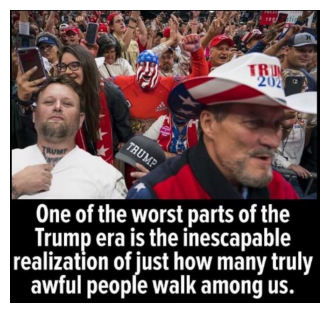

In [136]:
# visualizing a random meme

img_path = aug_df.iloc[210, 0]
img = mpimg.imread(img_path)
plt.figure(figsize=(4, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

Extracting image dimensions: 100%|██████████████████████████████████████████████████████| 2637/2637 [00:00<00:00, 5329.89it/s]


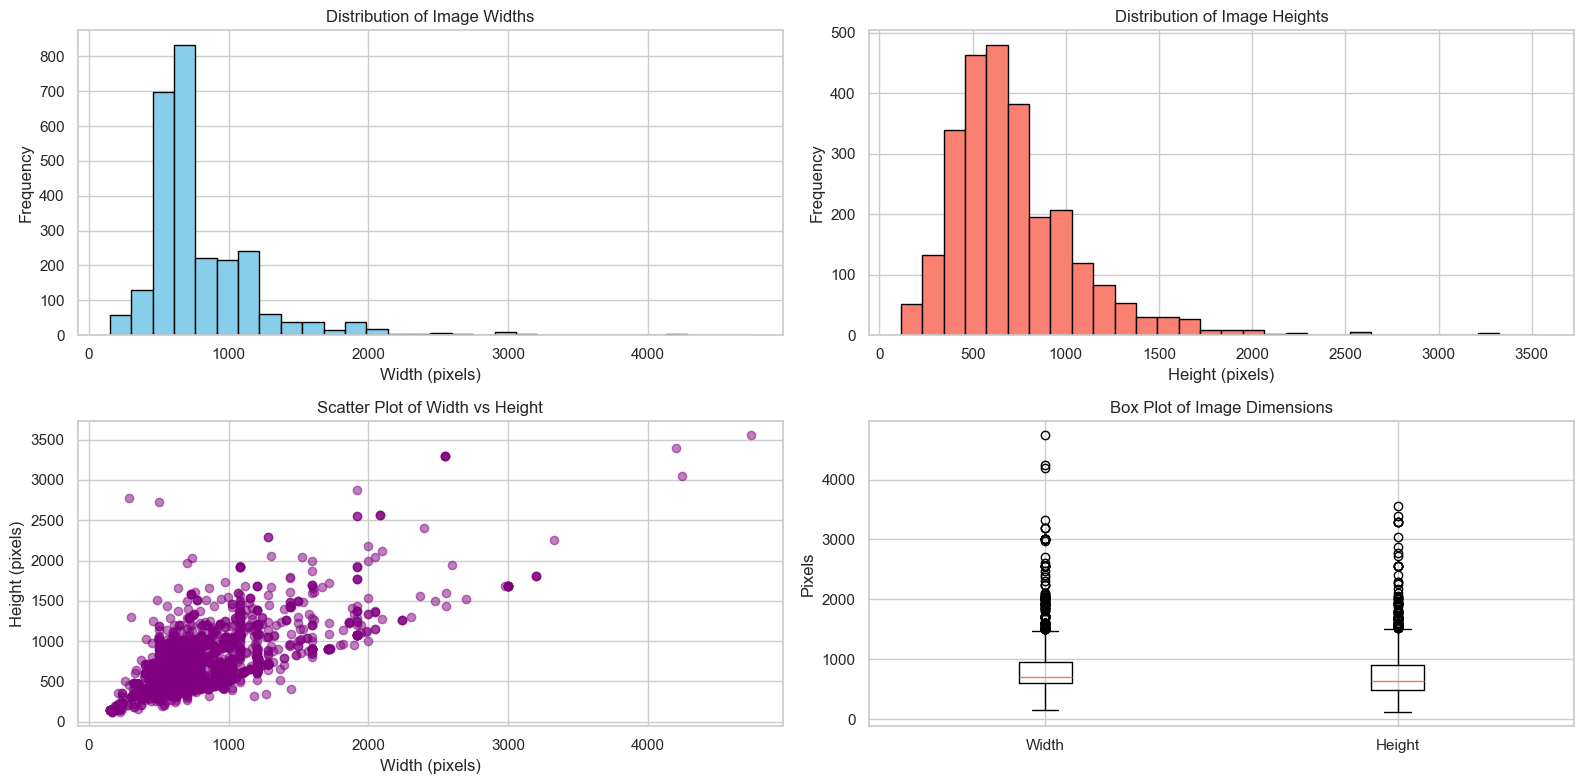

In [137]:
# Add width and height columns to the DataFrame
def extract_image_dimensions(df):
    widths, heights = [], []
    for path in tqdm(df['image_path'], desc="Extracting image dimensions"):
        try:
            with Image.open(path) as img:
                widths.append(img.width)
                heights.append(img.height)
        except Exception as e:
            widths.append(None)
            heights.append(None)
            print(f"Error with image {path}: {e}")
    df['width'] = widths
    df['height'] = heights
    return df

# Example: Extract dimensions
aug_df = extract_image_dimensions(aug_df)

# Visualization
plt.figure(figsize=(16, 8))

# Histogram for widths
plt.subplot(2, 2, 1)
plt.hist(aug_df['width'].dropna(), bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of Image Widths")
plt.xlabel("Width (pixels)")
plt.ylabel("Frequency")

# Histogram for heights
plt.subplot(2, 2, 2)
plt.hist(aug_df['height'].dropna(), bins=30, color='salmon', edgecolor='black')
plt.title("Distribution of Image Heights")
plt.xlabel("Height (pixels)")
plt.ylabel("Frequency")

# Scatter plot for width vs. height
plt.subplot(2, 2, 3)
plt.scatter(aug_df['width'], aug_df['height'], alpha=0.5, color='purple')
plt.title("Scatter Plot of Width vs Height")
plt.xlabel("Width (pixels)")
plt.ylabel("Height (pixels)")

# Box plot for dimensions
plt.subplot(2, 2, 4)
plt.boxplot([aug_df['width'].dropna(), aug_df['height'].dropna()], labels=['Width', 'Height'])
plt.title("Box Plot of Image Dimensions")
plt.ylabel("Pixels")

plt.tight_layout()
plt.show()


<div class="alert alert-info" role="alert">
There are some images which are outliers in terms of width and height. These images will be removed since resizing them will affect the aspect ratio of the image and affect the optical character recognition (OCR) output. The images which are more than 2000 pixels in width and 2500 pixels in height will be considered as outliers and subsequently removed. 
</div>

In [138]:
too_large = aug_df[(aug_df['width'] > 2000) | (aug_df['height'] > 2500)]
print(f"Number of images with width > 2000 or height > 2500: {len(too_large)}")

aug_df = aug_df[(aug_df['width'] <= 2000) & (aug_df['height'] <= 2500)]
print(f"Number of images after filtering: {len(aug_df)}")

Number of images with width > 2000 or height > 2500: 48
Number of images after filtering: 2589


In [139]:
def image_hash(image_path, size=(256, 256)):
    try:
        with Image.open(image_path) as img:
            img = img.convert('RGB').resize(size)
            img_bytes = img.tobytes()
            return hashlib.md5(img_bytes).hexdigest()
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None
    
def label_duplicates(df, size=(256, 256)):
    tqdm.pandas(desc="Computing image hashes")
    df['image_hash'] = df['image_path'].progress_apply(lambda path: image_hash(path, size))
    duplicate_hashes = df['image_hash'].value_counts()[df['image_hash'].value_counts() > 1].index
    df['duplicate'] = df['image_hash'].apply(lambda x: 1 if x in duplicate_hashes else 0)
    
    return df

aug_df = label_duplicates(aug_df)
aug_df.head()

Computing image hashes: 100%|█████████████████████████████████████████████████████████████| 2589/2589 [00:26<00:00, 95.97it/s]


image_path  label  width  height  \
0  ./dataset/violence against women meme offensiv...      1    575     500   
1  ./dataset/violence against women meme offensiv...      1    600     600   
2  ./dataset/violence against women meme offensiv...      1   1200    1095   
3  ./dataset/violence against women meme offensiv...      1    736     913   
4  ./dataset/violence against women meme offensiv...      1    600     692   

                         image_hash  duplicate  
0  421ba6dc0f109c51b090ca04509bce33          1  
1  aa4d925a75427431921a06ea8729acf5          1  
2  0d8a65051e1764e421af5fc897dd7ed8          0  
3  275ab8de6b3f9f53fb9fb9f3f18f2b4e          1  
4  8b32de0a2b61316aa3b5cda81dcd9fa8          1

<div class="alert alert-info" role="alert">
After looking through the folder with the images, it was observed that some of the scraped images were duplicated. These images will need to be identified and removed since it can lead to overfitting.
<br>
To remove duplicate images, hashing was used to hash the images and these hashes were compared. If the hash is equal it means the images are the same, and therefore only one of them needs to be retained. 
</div>

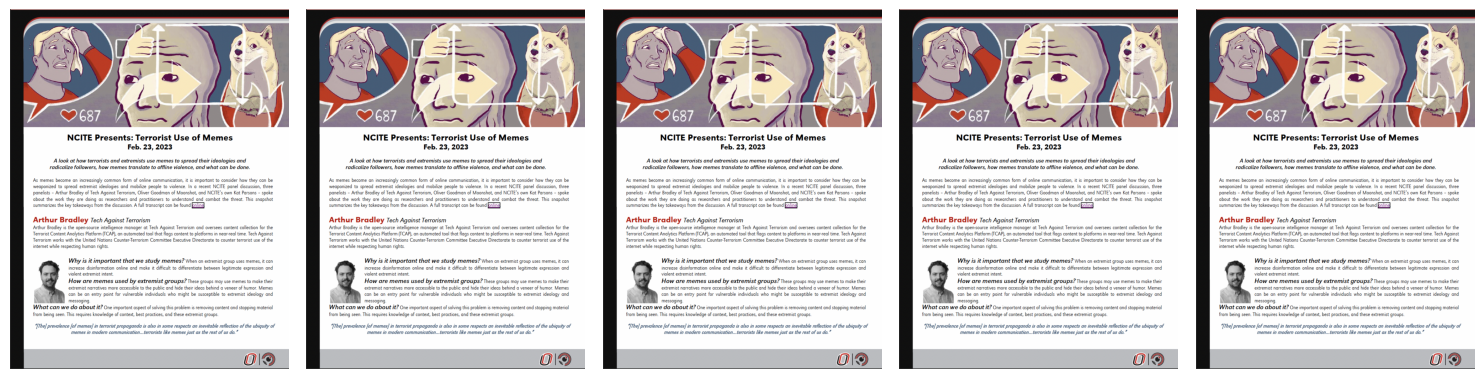

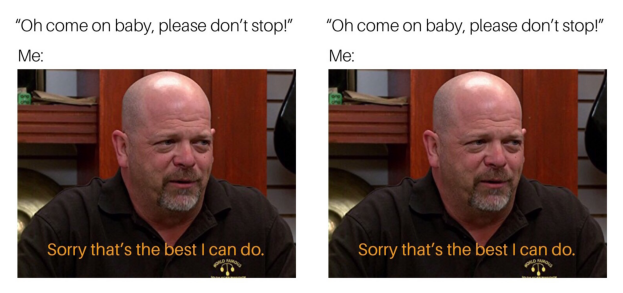

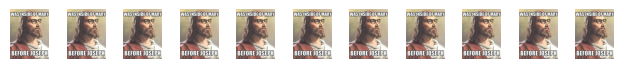

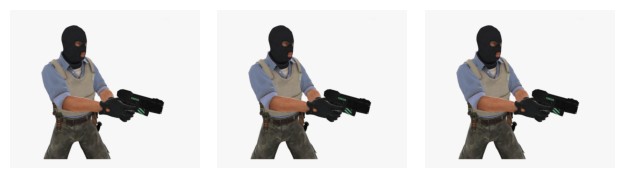

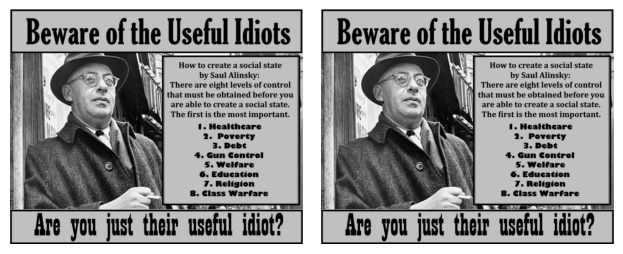

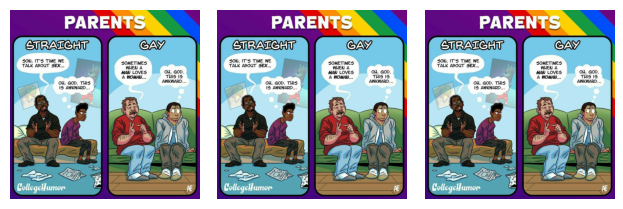

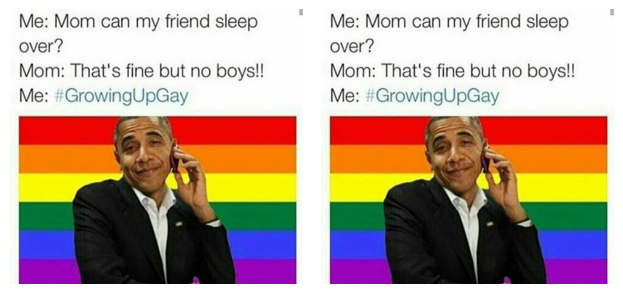

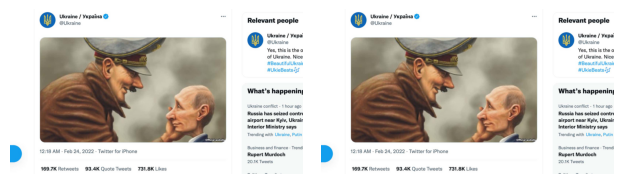

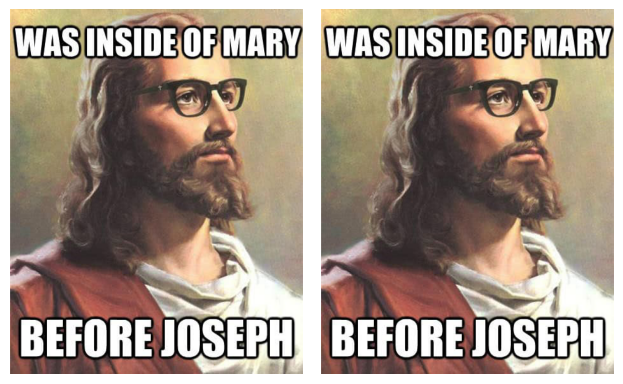

In [140]:
def display_duplicate_pairs(df, limit_num):
    duplicate_images = df[df['duplicate'] == 1]

    duplicate_groups = duplicate_images.groupby('image_hash')['image_path'].apply(list)

    plt.figure(figsize=(15, 5))
    
    i = 1
    for _, image_paths in duplicate_groups.items():
        if i > limit_num:
            break
        if len(image_paths) > 1:
            for j, image_path in enumerate(image_paths):
                img = Image.open(image_path)
                
                plt.subplot(1, len(image_paths), j + 1)
                plt.imshow(img)
                plt.axis('off')
            
            i += 1
            plt.tight_layout()
            plt.show()

display_duplicate_pairs(aug_df, limit_num=10)

In [51]:
def remove_duplicates(df):
    df_unique = df.drop_duplicates(subset='image_hash', keep='first')
    return df_unique

aug_df = remove_duplicates(aug_df)
aug_df.head()

image_path  label  width  height  \
0  ./dataset/violence against women meme offensiv...      1    575     500   
1  ./dataset/violence against women meme offensiv...      1    600     600   
2  ./dataset/violence against women meme offensiv...      1   1200    1095   
3  ./dataset/violence against women meme offensiv...      1    736     913   
4  ./dataset/violence against women meme offensiv...      1    600     692   

                         image_hash  duplicate  
0  421ba6dc0f109c51b090ca04509bce33          1  
1  aa4d925a75427431921a06ea8729acf5          1  
2  0d8a65051e1764e421af5fc897dd7ed8          0  
3  275ab8de6b3f9f53fb9fb9f3f18f2b4e          1  
4  8b32de0a2b61316aa3b5cda81dcd9fa8          1

In [52]:
aug_df.shape

(1751, 6)

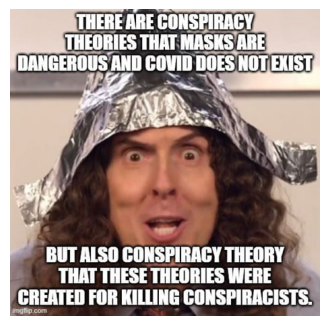

In [143]:
img_path = aug_df.iloc[120, 0]
img = mpimg.imread(img_path)
plt.figure(figsize=(4, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

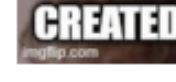
<div class="alert alert-info" role="alert">
The next step will be to remove the watermarks and small texts that do not contribute much to the analysis and affect the OCR output. Like in the above meme, bottom right corner, there is a imgflip.com small text watermark which is unnecessary to the analysis. 
</div>

In [165]:
# ! pip install python-doctr
# # for TensorFlow
# ! pip install "python-doctr[tf]"

In [ ]:
from doctr.io import DocumentFile
from doctr.models import ocr_predictor
model = ocr_predictor(det_arch = 'db_resnet50',
                      reco_arch = 'crnn_vgg16_bn',
                      pretrained = True
                     )

In [162]:
def area_filter(min_area, input_image):
    # Perform connected components analysis
    components_number, labeled_image, component_stats, _ = cv2.connectedComponentsWithStats(input_image, connectivity=4)
    
    # Get labels of components with area >= min_area
    remaining_labels = [i for i in range(1, components_number) if component_stats[i][cv2.CC_STAT_AREA] >= min_area]
    
    # Filter the labeled pixels based on the remaining labels
    filtered_image = np.where(np.isin(labeled_image, remaining_labels), 255, 0).astype(np.uint8)
    return filtered_image

def remove_watermark(image, min_area_big=700, min_area_small=10, inpaint_radius=20):
    original_img = image.copy()

    # Convert to float and normalize
    img_float = image.astype(np.float32) / 255.0

    # Calculate the K channel
    k_channel = 1 - np.max(img_float, axis=2)

    # Adjust brightness/contrast for better text segmentation
    alpha = 0
    beta = 1.2
    adjusted_k = cv2.normalize(k_channel, None, alpha, beta, cv2.NORM_MINMAX, cv2.CV_32F)
    adjusted_k = (255 * adjusted_k).astype(np.uint8)

    # Apply adaptive thresholding
    binary_img = cv2.adaptiveThreshold(
        adjusted_k, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 25, 11
    )

    # Filter big and small blobs
    big_blobs = area_filter(min_area_big, binary_img)
    small_blobs = area_filter(min_area_small, binary_img)

    # Isolate text mask by subtracting big blobs from small blobs
    text_mask = cv2.subtract(small_blobs, big_blobs)

    # Apply Gaussian blur to smooth the mask
    text_mask = cv2.GaussianBlur(text_mask, (3, 3), cv2.BORDER_DEFAULT)

    # Apply inpainting
    result = cv2.inpaint(original_img, text_mask, inpaint_radius, cv2.INPAINT_TELEA)

    return result, text_mask


def preprocess_image_for_ocr(im, resize_dim=(1280, 1024)):
    # Resize the image to a consistent size
    im_resized = cv2.resize(im, resize_dim, interpolation=cv2.INTER_LINEAR)
    
    # Convert to grayscale for OCR
    im_gray = cv2.cvtColor(im_resized, cv2.COLOR_BGR2GRAY)
    
    # Apply adaptive thresholding to make text stand out
    im_thresh = cv2.adaptiveThreshold(im_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                     cv2.THRESH_BINARY_INV, 11, 2)

    # Perform morphological closing to remove small artifacts
    kernel = np.ones((5, 5), np.uint8)
    im_morph = cv2.morphologyEx(im_thresh, cv2.MORPH_CLOSE, kernel)

    return im_morph

def extract_and_correct_text(image):
    # Step 1: Use pytesseract to extract text from the image
    custom_config = r"--oem 3 --psm 6 -c tessedit_char_whitelist='ABCDEFGHIJKLMNOPQRSTUVWXYZ '"
    text = pytesseract.image_to_string(image, lang='eng', config=custom_config)

    # Clean the extracted text (remove extra spaces and newlines)
    cleaned_text = ' '.join(text.split()).replace('\n', ' ').strip()

    # Step 2: Use LanguageTool to correct the grammar of the extracted text
    tool = language_tool_python.LanguageTool('en-US')
    matches = tool.check(cleaned_text)
    corrected_text = language_tool_python.utils.correct(cleaned_text, matches)

    return corrected_text, text

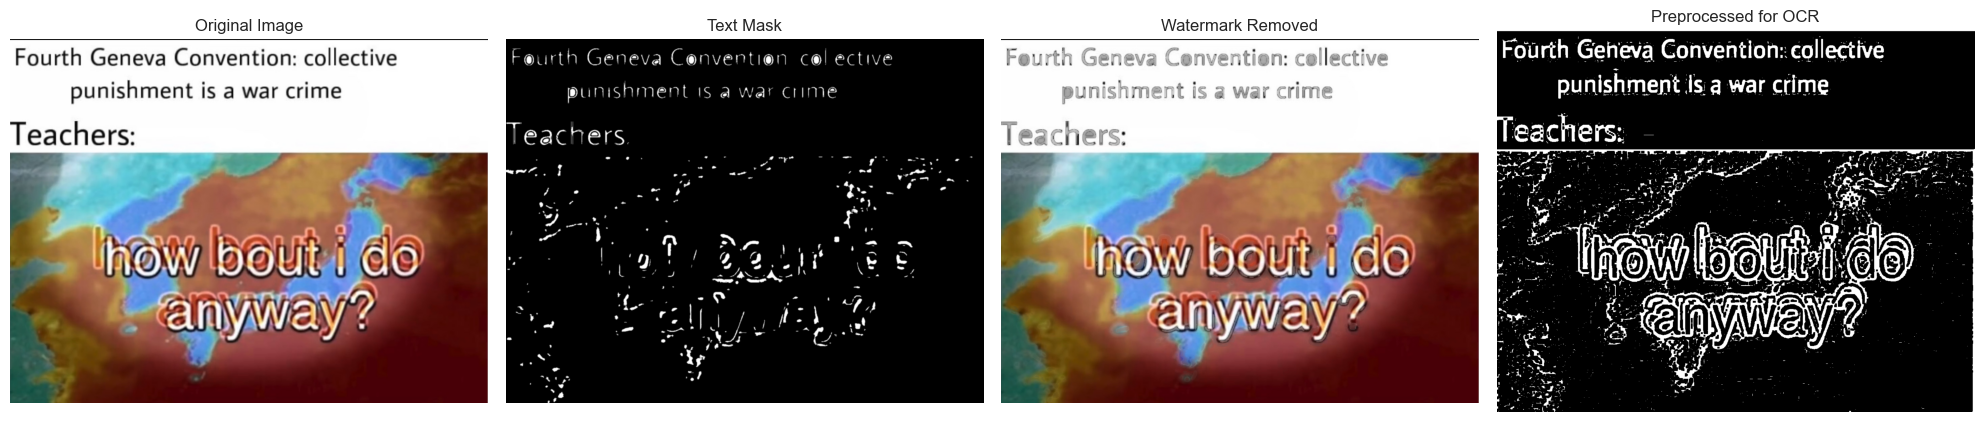

Original Text Extracted:
F G C
P  W

T

TROT

SGN


Corrected Text:
F G C P W T TROT SGN


In [163]:
img_path = aug_df.iloc[230, 0]
img = np.array(Image.open(img_path))

# Step 1: Remove watermarks
result, text_mask = remove_watermark(img)

# Step 2: Preprocess the image for OCR
preprocessed_img = preprocess_image_for_ocr(result)

# Step 3: Perform OCR and correct the extracted text
corrected_text, original_text = extract_and_correct_text(preprocessed_img)

# Visualize intermediate results
plt.figure(figsize=(20, 10))

# Original image
plt.subplot(1, 4, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis('off')

# Text mask
plt.subplot(1, 4, 2)
plt.imshow(text_mask, cmap='gray')
plt.title("Text Mask")
plt.axis('off')

# Watermark removed
plt.subplot(1, 4, 3)
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.title("Watermark Removed")
plt.axis('off')

# Preprocessed for OCR
plt.subplot(1, 4, 4)
plt.imshow(preprocessed_img, cmap='gray')
plt.title("Preprocessed for OCR")
plt.axis('off')

plt.tight_layout()
plt.show()

# Print the results
print("Original Text Extracted:")
print(original_text)

print("\nCorrected Text:")
print(corrected_text)

Original Text Extracted:
SUS
RECITES EOKN EWS TALKING
SROINTSIANVUGIAW


Corrected Text:
SUS RECITES EON EWS TALKING SROINTSIANVUGIAW


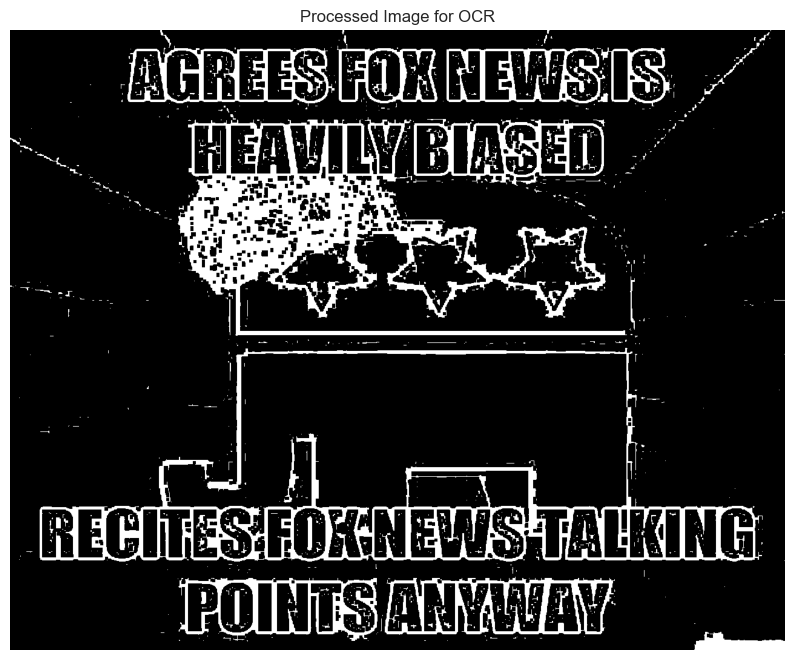

In [ ]:
def preprocess_image_for_ocr(im, resize_dim=(1280, 1024)):
    # Resize the image to a consistent size
    im_resized = cv2.resize(im, resize_dim, interpolation=cv2.INTER_LINEAR)
    
    # Convert to grayscale for OCR
    im_gray = cv2.cvtColor(im_resized, cv2.COLOR_BGR2GRAY)
    
    # Apply adaptive thresholding to make text stand out
    im_thresh = cv2.adaptiveThreshold(im_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                     cv2.THRESH_BINARY_INV, 11, 2)

    # Perform morphological closing to remove small artifacts
    kernel = np.ones((5, 5), np.uint8)
    im_morph = cv2.morphologyEx(im_thresh, cv2.MORPH_CLOSE, kernel)

    return im_morph

# Function to use pytesseract and language tool to extract and correct text
def extract_and_correct_text(image_path):
    # Convert image to OpenCV format
    img = np.array(Image.open(image_path))

    # Step 1: Preprocess the image for OCR
    final_im = preprocess_image_for_ocr(img)

    # Step 2: Use pytesseract to extract text from the image
    custom_config = r"--oem 3 --psm 6 -c tessedit_char_whitelist='ABCDEFGHIJKLMNOPQRSTUVWXYZ '"
    text = pytesseract.image_to_string(final_im, lang='eng', config=custom_config)

    # Clean the extracted text (remove extra spaces and newlines)
    cleaned_text = ' '.join(text.split()).replace('\n', ' ').strip()

    # Step 3: Use LanguageTool to correct the grammar of the extracted text
    tool = language_tool_python.LanguageTool('en-US')
    matches = tool.check(cleaned_text)
    corrected_text = language_tool_python.utils.correct(cleaned_text, matches)

    return corrected_text, text

# Extract and correct the text
corrected_text, original_text = extract_and_correct_text(img_path)

# Print the original and corrected texts
print("Original Text Extracted:")
print(original_text)

print("\nCorrected Text:")
print(corrected_text)

# Plot the final processed image (for debugging/visualization)
img = np.array(Image.open(img_path))
processed_img = preprocess_image_for_ocr(img)

# Show the processed image (with thresholding and morphological closing applied)
plt.figure(figsize=(10, 10))
plt.title('Processed Image for OCR')
plt.imshow(processed_img, cmap='gray')
plt.axis('off')
plt.show()

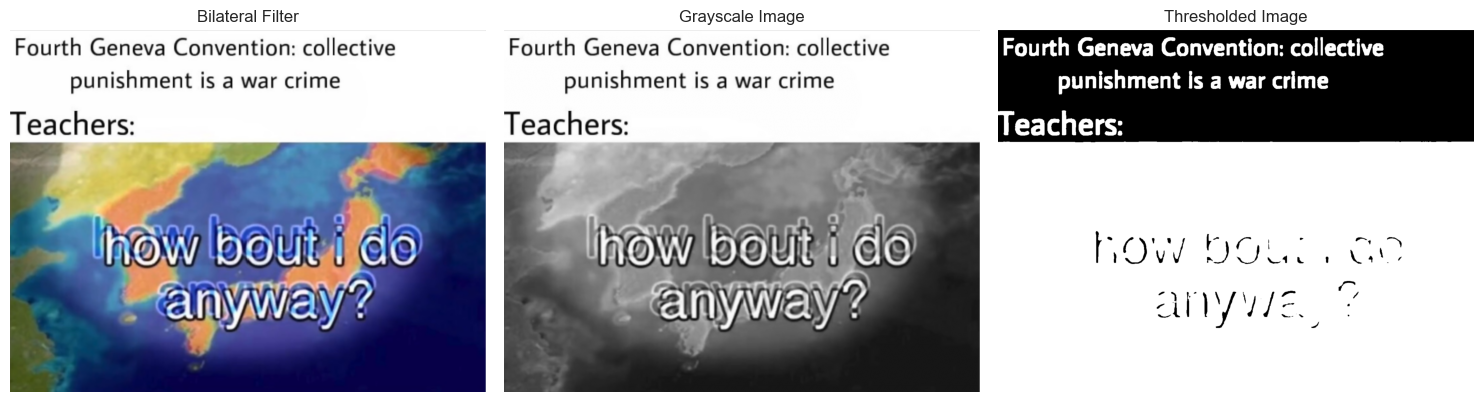

ORIGINAL TEXT: F G C  I DOW D GO EVV JO FA L 
CORRECTED TEXT: F G C I DOW D GO EVE JO FA L


In [158]:
# Function to preprocess the image (bilateral filter, grayscale, and thresholding)
def preprocess_image_for_ocr(im, resize_dim=(1280, 1024)):
    # Resize the image to a consistent size
    im_resized = cv2.resize(im, resize_dim, interpolation=cv2.INTER_LINEAR)
    
    # Convert to grayscale for OCR
    im_gray = cv2.cvtColor(im_resized, cv2.COLOR_BGR2GRAY)
    
    # Apply adaptive thresholding to make text stand out
    im_thresh = cv2.adaptiveThreshold(im_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                     cv2.THRESH_BINARY_INV, 11, 2)

    # Perform morphological closing to remove small artifacts
    kernel = np.ones((5, 5), np.uint8)
    im_morph = cv2.morphologyEx(im_thresh, cv2.MORPH_CLOSE, kernel)

    return im_morph

def preprocess_finale(im):
    # Apply bilateral filter
    im = cv2.bilateralFilter(im, 5, 55, 60)
    # Convert to grayscale
    im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    # Apply thresholding
    _, im = cv2.threshold(im, 240, 255, 1)
    return im

# Path to the image in the DataFrame
img_path = aug_df.iloc[230, 0]
img = mpimg.imread(img_path)

# Convert image to OpenCV format
im = np.array(Image.open(img_path))

# Step 1: Apply Bilateral Filter
im_bilateral = cv2.bilateralFilter(im, 5, 55, 60)

# Step 2: Convert to Grayscale
im_gray = cv2.cvtColor(im_bilateral, cv2.COLOR_BGR2GRAY)

# Step 3: Apply Thresholding
_, im_threshold = cv2.threshold(im_gray, 240, 255, 1)

# Show the intermediate steps
plt.figure(figsize=(15, 5))

# Plot the Bilateral Filtered image
plt.subplot(1, 3, 1)
plt.title('Bilateral Filter')
plt.imshow(im_bilateral)
plt.axis('off')

# Plot the Grayscale image
plt.subplot(1, 3, 2)
plt.title('Grayscale Image')
plt.imshow(im_gray, cmap='gray')
plt.axis('off')

# Plot the Thresholded image
plt.subplot(1, 3, 3)
plt.title('Thresholded Image')
plt.imshow(im_threshold, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

# Final preprocessing
final_im = preprocess_finale(im)

# Use pytesseract to get the text
custom_config = r"--oem 3 --psm 6 -c tessedit_char_whitelist='ABCDEFGHIJKLMNOPQRSTUVWXYZ '"
text = pytesseract.image_to_string(final_im, lang='eng', config=custom_config)

# Print the extracted text
print("ORIGINAL TEXT:", text.replace('\n', ' '))
cleaned_text = ' '.join(text.split()).replace('\n', ' ').strip()

# Grammar correction using LanguageTool
tool = language_tool_python.LanguageTool('en-US')
matches = tool.check(cleaned_text)
corrected_text = language_tool_python.utils.correct(cleaned_text, matches)
print("CORRECTED TEXT:", corrected_text)

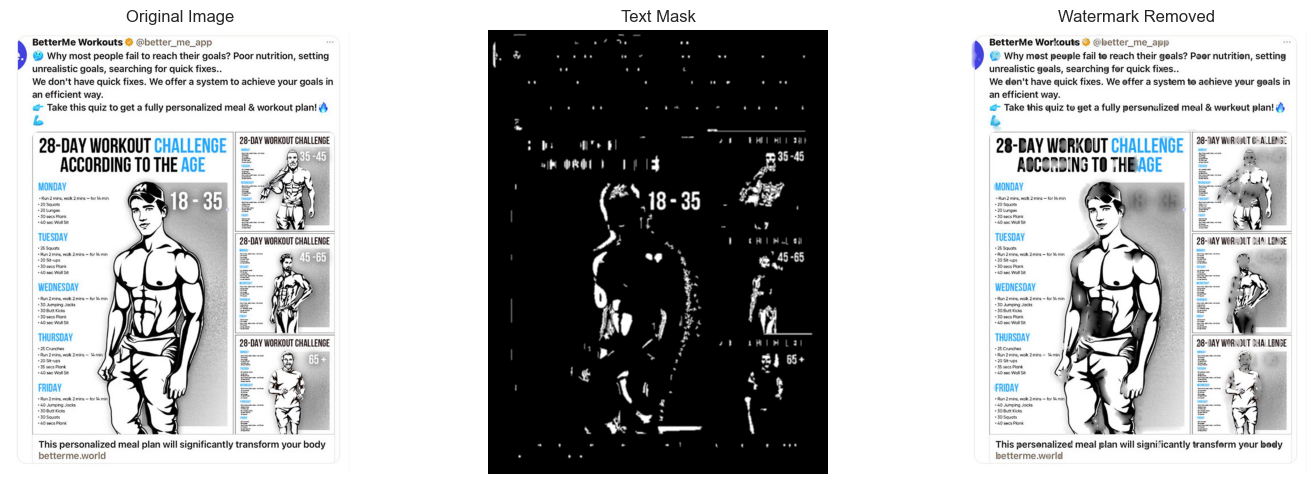

In [ ]:
def area_filter(min_area, input_image):
    # Perform connected components analysis
    components_number, labeled_image, component_stats, _ = cv2.connectedComponentsWithStats(input_image, connectivity=4)
    
    # Get labels of components with area >= min_area
    remaining_labels = [i for i in range(1, components_number) if component_stats[i][cv2.CC_STAT_AREA] >= min_area]
    
    # Filter the labeled pixels based on the remaining labels
    filtered_image = np.where(np.isin(labeled_image, remaining_labels), 255, 0).astype(np.uint8)
    return filtered_image


def remove_watermark(image, min_area_big=700, min_area_small=10, inpaint_radius=20):
    original_img = image.copy()

    # Convert to float and normalize
    img_float = image.astype(np.float32) / 255.0

    # Calculate the K channel
    k_channel = 1 - np.max(img_float, axis=2)

    # Adjust brightness/contrast for better text segmentation
    alpha = 0
    beta = 1.2
    adjusted_k = cv2.normalize(k_channel, None, alpha, beta, cv2.NORM_MINMAX, cv2.CV_32F)
    adjusted_k = (255 * adjusted_k).astype(np.uint8)

    # Apply adaptive thresholding
    binary_img = cv2.adaptiveThreshold(
        adjusted_k, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 21, 11
    )

    # Filter big and small blobs
    big_blobs = area_filter(min_area_big, binary_img)
    small_blobs = area_filter(min_area_small, binary_img)

    # Isolate text mask by subtracting big blobs from small blobs
    text_mask = cv2.subtract(small_blobs, big_blobs)

    # Apply Gaussian blur to smooth the mask
    text_mask = cv2.GaussianBlur(text_mask, (3, 3), cv2.BORDER_DEFAULT)

    # Apply inpainting
    result = cv2.inpaint(original_img, text_mask, inpaint_radius, cv2.INPAINT_TELEA)

    return result, text_mask


# Remove watermark

img_path = aug_df.iloc[230, 0]
img = np.array(Image.open(img_path))
result, text_mask = remove_watermark(img)

# Display results
plt.figure(figsize=(15, 5))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis('off')

# Text mask
plt.subplot(1, 3, 2)
plt.imshow(text_mask, cmap='gray')
plt.title("Text Mask")
plt.axis('off')

# Result image
plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.title("Watermark Removed")
plt.axis('off')

plt.tight_layout()
plt.show()

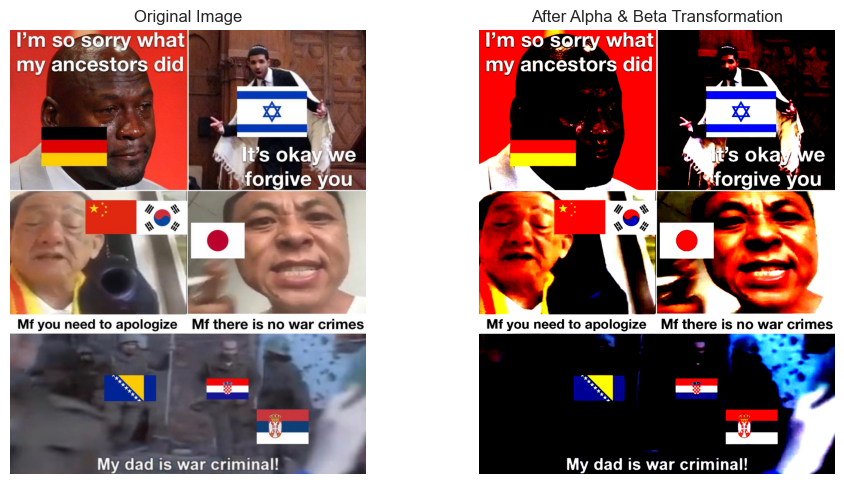

In [159]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Load the image
img_path = aug_df.iloc[220, 0]
img = np.array(Image.open(img_path))

# Apply the transformation using alpha and beta
alpha = 5.0  # Contrast control (1.0 gives original image)
beta = -600  # Brightness control (0 gives original image)

new = alpha * img + beta
new = np.clip(new, 0, 255).astype(np.uint8)

# Create a subplot to display both images
plt.figure(figsize=(10, 5))

# Plot the original image
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original Image")
plt.axis('off')

# Plot the transformed image
plt.subplot(1, 2, 2)
plt.imshow(new)
plt.title("After Alpha & Beta Transformation")
plt.axis('off')

plt.tight_layout()
plt.show()

In [488]:
result2 = ' '.join(reader.readtext(img_path, detail = 0))
result2

"DON'T WORRY ABOUT GETTING OLDER YOURE STILL GONNA DO DUMB STUFF, ONLY SLOWER"

In [555]:
from mlx_lm import load, generate

model, tokenizer = load("HuggingFaceTB/SmolLM2-135M-Instruct-Q8-mlx")
result1 = "v jim"

prompt=f"Does the following sentence make sense: '{result1}'. Reply with 'Yes' or 'No'."

if hasattr(tokenizer, "apply_chat_template") and tokenizer.chat_template is not None:
    messages = [{"role": "user", "content": prompt}]
    prompt = tokenizer.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=False
    )

response = generate(model, tokenizer, prompt=prompt, verbose=True, temp=0.5, max_tokens=5)

Fetching 8 files: 100%|██████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41425.22it/s]


Prompt: <|im_start|>system
You are a helpful AI assistant named SmolLM, trained by Hugging Face<|im_end|>
<|im_start|>user
Does the following sentence make sense: 'v jim'. Reply with 'Yes' or 'No'.<|im_end|>

[Warning] Specifying sampling arguments to ``generate_step`` is deprecated. Pass in a ``sampler`` instead.
<|im_start|>assistant
The
Prompt: 48 tokens, 928.887 tokens-per-sec
Generation: 5 tokens, 155.748 tokens-per-sec
Peak memory: 0.579 GB


In [576]:
from nostril import ng
from nostril import nonsense_detector as nd

def is_nonsense_text(text):
    if nd.nonsense(text):
        return 1
    else:
        return 0
    
is_nonsense_text("OM KMS A X AN GEESE A ASR SO")

0